# Fetching Data

In [3]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn

In [4]:
root_path = "WESAD"
zip_label = "_E4_Data.zip"
E4_label = "_E4_Data"

In [5]:
pacient_state = {
    0: "Not Defined/Transient",
    1: "Baseline",
    2: "Stress",
    3: "Amusement",
    4: "Meditation",
    5: "Error/Not Labeled"
}

In [6]:
chest_signal_available = ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']

In [7]:
subjects_available = os.listdir(root_path)

subjects_available

['S5',
 'S2',
 'S3',
 'S4',
 'S17',
 'S10',
 'S11',
 'S16',
 'S8',
 'S6',
 'S7',
 'S9',
 'S13',
 'S14',
 'S15']

In [8]:
def get_input_chest_data(subjects_list):
    
    chest_df_list = []
    
    for subject in subjects_list:
        
        pkl_path = os.path.join(root_path, subject, subject + ".pkl")
        f=open(pkl_path,'rb')
        data=pickle.load(f,encoding='latin1')
        
        index_df = [i for i in range(1, len(data["label"]) + 1)]

        chest_data = {
            body_signal: data["signal"]["chest"][body_signal].reshape(len(data["signal"]["chest"][body_signal]),)
            for body_signal in chest_signal_available
        }
        chest_data["label_id"] = [label if (label >= 0) and (label < 6) else 5 for label in data["label"]]
        chest_data["label"] = [pacient_state[label] if (label >= 0) and (label < 6) else pacient_state[5] for label in data["label"]]
        chest_data["subject"] = data["subject"]

        chest_df_list.append(pd.DataFrame(chest_data, index = index_df))
        
    return chest_df_list

In [9]:
input_chest_data = get_input_chest_data(subjects_available)

# Investigating Data

In [10]:
sample_df = input_chest_data[0]

sample_df.sample(20)

,ECG,EMG,EDA,Temp,Resp,label_id,label,subject
218363,0.071960,0.031815,5.960846,34.396393,3.205872,1,Baseline,S5
850098,-0.069855,-0.009109,3.695679,34.823120,0.416565,1,Baseline,S5
304012,0.284546,-0.054794,4.859543,34.483704,-2.792358,1,Baseline,S5
267321,1.427536,-0.013138,5.308914,34.472961,-0.331116,1,Baseline,S5
59365,0.002747,0.014236,5.240250,34.139740,4.612732,0,Not Defined/Transient,S5
3133739,0.103592,-0.009109,11.183548,34.329102,-4.539490,5,Error/Not Labeled,S5
2233808,-0.045364,-0.014191,8.775711,34.997314,4.656982,0,Not Defined/Transient,S5
1473418,0.096909,-0.007919,5.844498,34.949463,-0.254822,3,Amusement,S5
3750338,0.055756,-0.009659,7.397842,34.523560,10.563660,0,Not Defined/Transient,S5
1084556,1.499130,-0.002975,6.163788,34.746185,0.242615,5,Error/Not Labeled,S5


In [11]:
sample_df["label_id"].unique()

array([0, 1, 5, 3, 4, 2])

<AxesSubplot:>

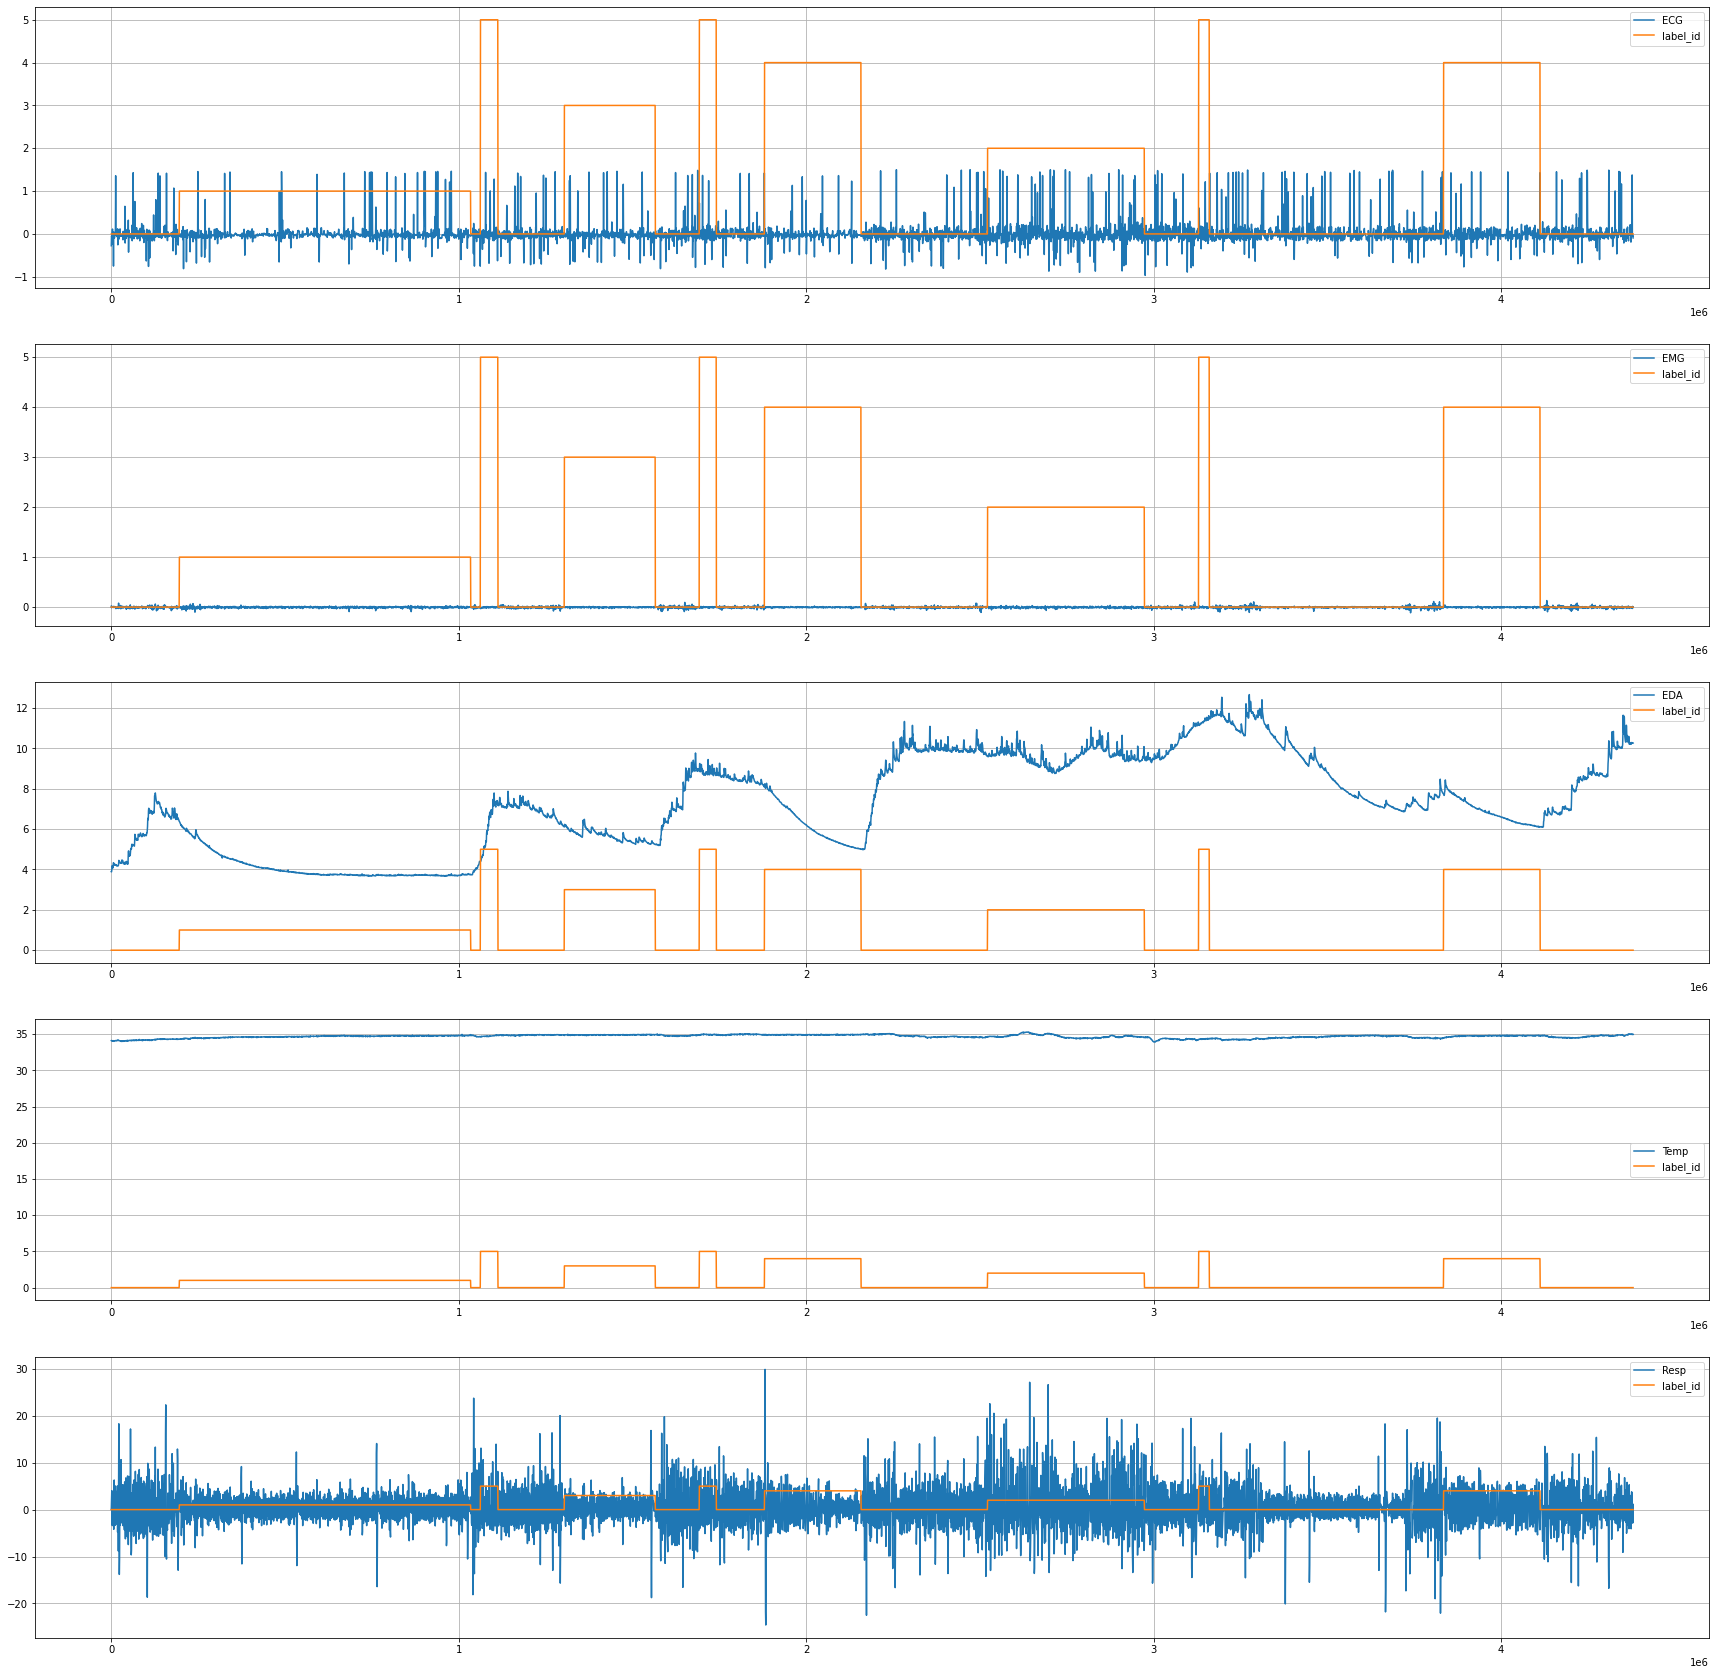

In [12]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1)

sample_df[::700].plot(figsize=(30, 30), grid=True, y=["ECG", "label_id"], ax=ax1)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EMG", "label_id"], ax=ax2)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["EDA", "label_id"], ax=ax3)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Temp", "label_id"], ax=ax4)
sample_df[::700].plot(figsize=(30, 30), grid=True, y=["Resp", "label_id"], ax=ax5)

In [13]:
sample_corr_df  = sample_df.corr("pearson")

sample_corr_df

,ECG,EMG,EDA,Temp,Resp,label_id
ECG,1.000000,-0.038543,-0.000210,-0.000223,-0.005208,0.000061
EMG,-0.038543,1.000000,-0.021898,-0.006276,-0.000312,0.003988
EDA,-0.000210,-0.021898,1.000000,-0.213464,-0.003151,-0.186922
Temp,-0.000223,-0.006276,-0.213464,1.000000,0.001937,0.346217
Resp,-0.005208,-0.000312,-0.003151,0.001937,1.000000,0.000427
label_id,0.000061,0.003988,-0.186922,0.346217,0.000427,1.000000


<AxesSubplot:>

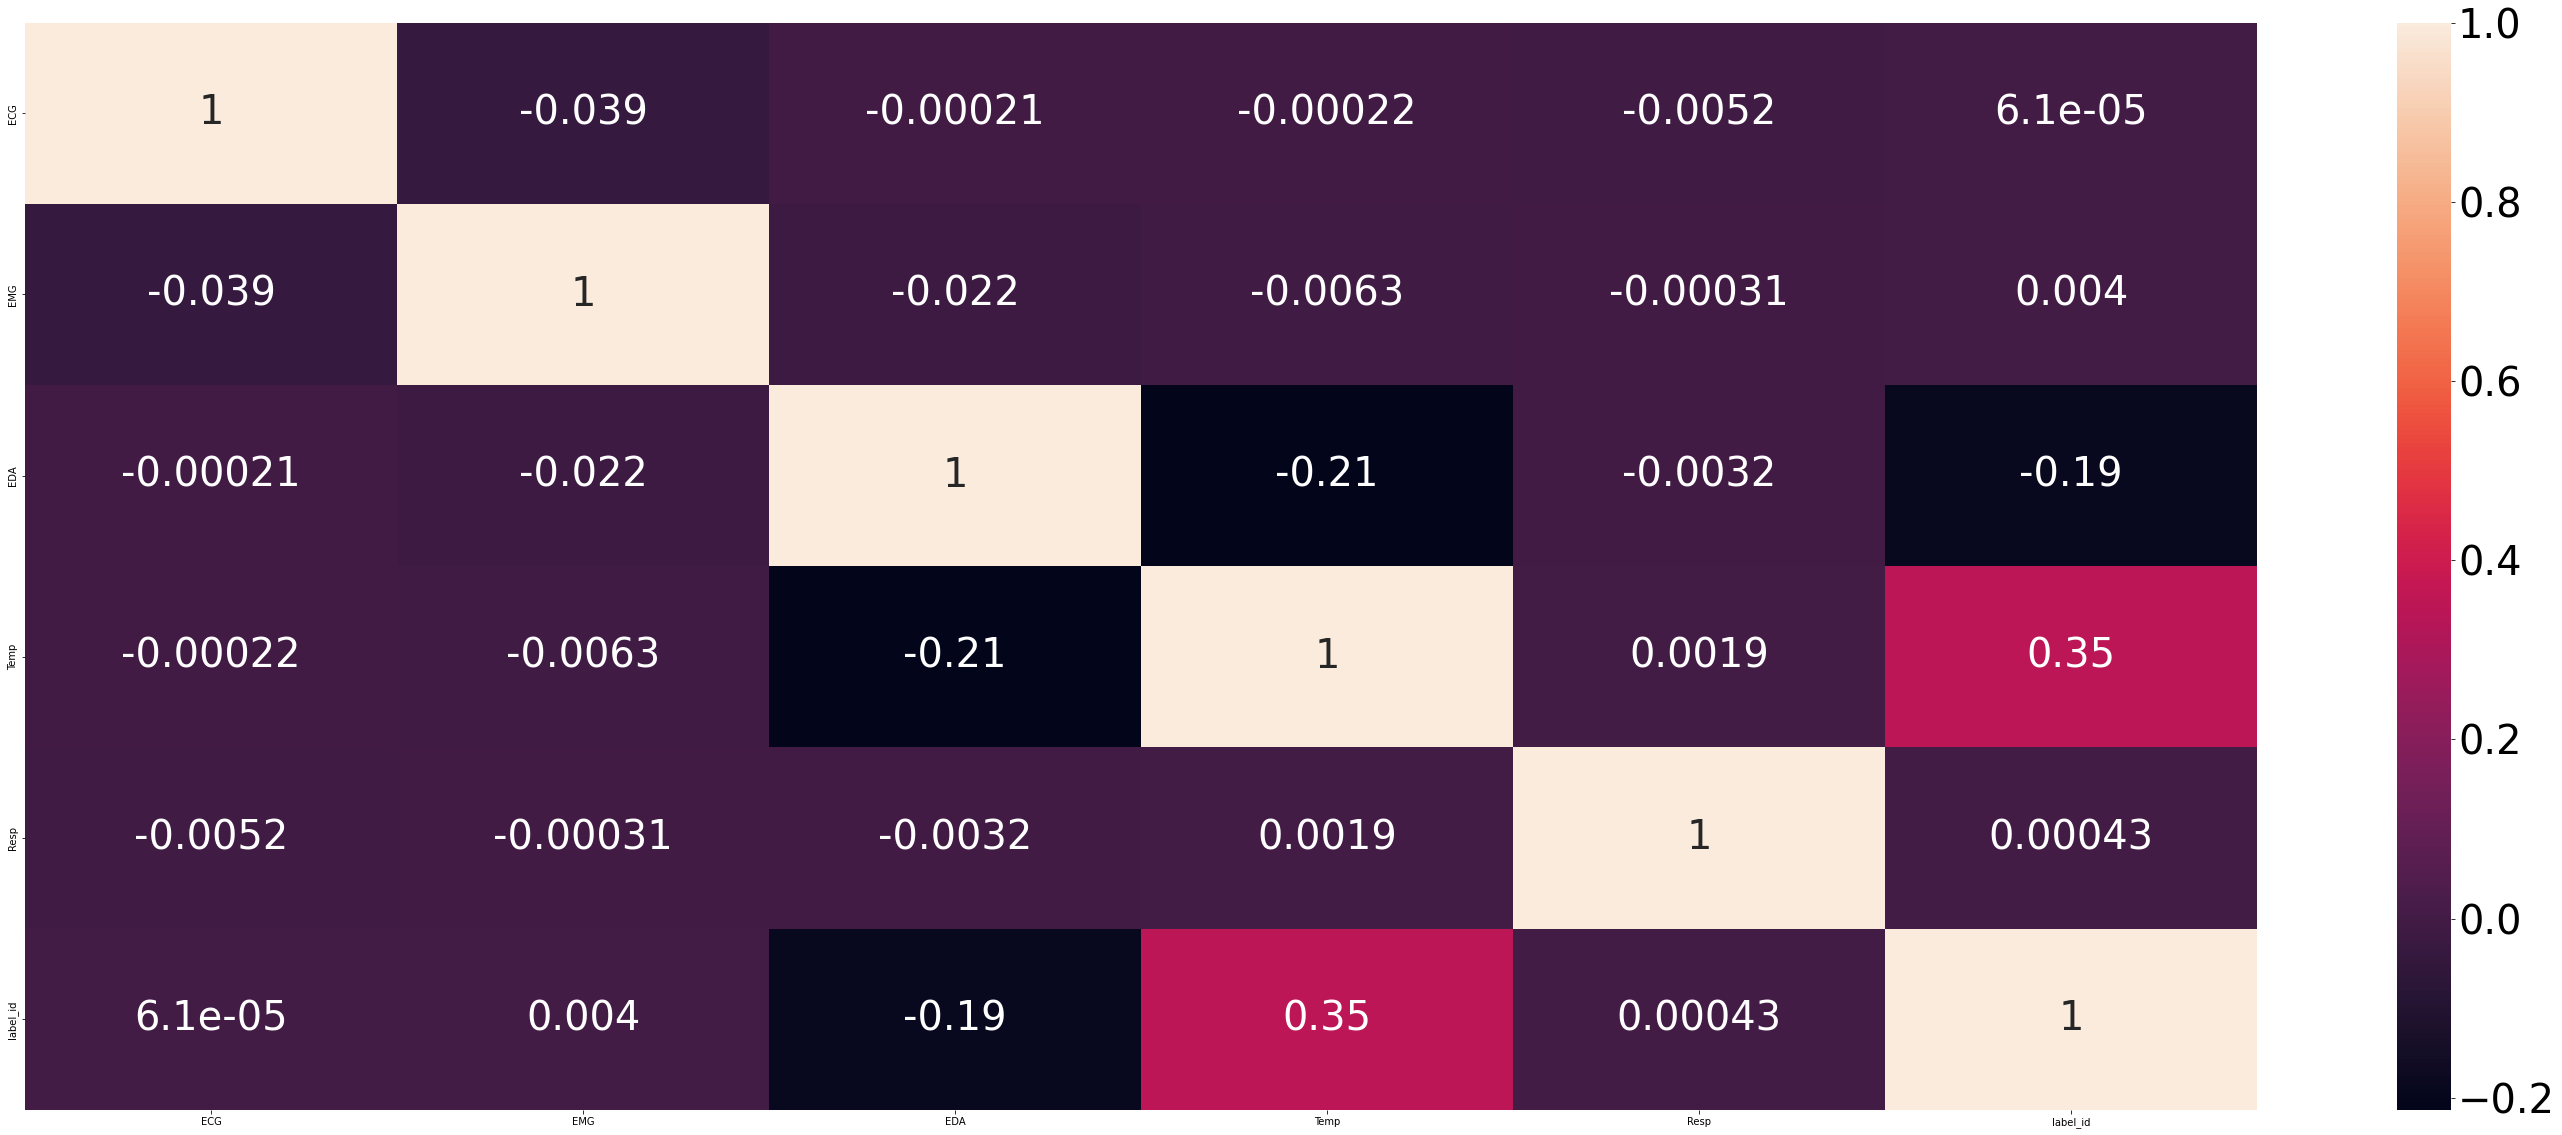

In [14]:
fig,ax_corr = plt.subplots(1, 1, figsize=(50,20))
plt.rcParams.update({'font.size': 40})

sn.heatmap(sample_corr_df, annot=True, ax=ax_corr)

# Cleaning Data

In [15]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [16]:
pacient_state_list  = [[state, pacient_state[state]] for state in pacient_state]

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(pacient_state_list)

enc.categories_

[array([0, 1, 2, 3, 4, 5], dtype=object),
 array(['Amusement', 'Baseline', 'Error/Not Labeled', 'Meditation',
        'Not Defined/Transient', 'Stress'], dtype=object)]

In [17]:
win_size = 60 # represent 1 minute

def simple_rolling_z_score(x, window):
    r = x.rolling(window=window)
    m = r.mean()
    s = r.std(ddof=0)
    z = (x-m)/s
    return z

In [18]:
def rolling_z_score(df, win_size):

    copy_df = df.copy()

    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        mean = df[slicer].mean()
        std = df[slicer].std(ddof=0)

        copy_df[slicer] = (df[slicer] - mean) / std

    return copy_df


In [19]:
clean_chest_data = []

for data_df in input_chest_data:

    # resampling data choosing one point each 700 points

    resample_data_df = data_df[::700]

    # apllying one hot encoder

    # label = resample_data_df.pop("label").to_numpy()
    # label_id = resample_data_df.pop("label_id").to_numpy()
    resample_data_df.pop("label")

    # label_list = [[label_id[i], label[i]] for i in range(len(resample_data_df))]

    # target = enc.transform(label_list).toarray()

    target = resample_data_df.pop("label_id").to_numpy()

    # applying rolling score-z

    subject_label = resample_data_df.pop("subject").to_numpy()[0]

    nodmalized_data_df = rolling_z_score(
        resample_data_df,
        win_size
    )

    # tuple = (normalized_data_df, target, subject_label)

    clean_chest_data.append((nodmalized_data_df, target, subject_label))



In [20]:
sample = clean_chest_data[0]

In [21]:
sample

(              ECG       EMG       EDA      Temp      Resp
 1       -1.141354  1.010902 -3.086350  0.761450  0.014113
 701     -0.180240 -0.664806 -3.502281  0.003950  0.354657
 1401    -0.274072  0.947775 -3.141712  0.444722  0.807513
 2101     0.051459  0.534775 -1.374533  0.391319 -0.447787
 2801     0.203342  0.187253 -1.059586 -0.591657 -0.676844
 ...           ...       ...       ...       ...       ...
 4377101  3.688604  0.490229 -0.347143  1.430297  1.046071
 4377801 -0.220608 -1.806449 -0.304009  1.203311 -0.949383
 4378501 -0.370882  1.531488 -0.285798  0.852218 -0.178434
 4379201 -0.321395 -0.591647 -0.291549  0.233314  0.324026
 4379901 -0.474520  0.877932 -0.326055  0.686877 -0.914863
 
 [6258 rows x 5 columns],
 array([0, 0, 0, ..., 0, 0, 0]),
 'S5')

In [22]:
sample_data_df = sample[0]

In [23]:
sample_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ECG,6258.0,-0.008513,1.004793,-6.563428,-0.307366,-0.116652,0.119997,7.582440
EMG,6258.0,0.000242,1.035429,-6.152012,-0.568847,0.044271,0.590430,5.852986
EDA,6258.0,0.345882,1.400994,-4.466730,-0.764205,0.376400,1.631442,5.557065
Temp,6258.0,-0.156492,1.214242,-4.190432,-0.991951,-0.072184,0.701792,4.071720
Resp,6258.0,-0.003516,1.021687,-5.952565,-0.662984,-0.139023,0.654771,4.669473


In [24]:
sample_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6258 entries, 1 to 4379901
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ECG     6258 non-null   float64
 1   EMG     6258 non-null   float64
 2   EDA     6258 non-null   float64
 3   Temp    6258 non-null   float32
 4   Resp    6258 non-null   float64
dtypes: float32(1), float64(4)
memory usage: 268.9 KB


In [25]:
sample_target = sample[1]

In [26]:
sample_target

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
unique_values = np.unique(sample_target, axis=0)

In [28]:
unique_values

array([0, 1, 2, 3, 4, 5])

In [29]:
# decode_unique_values = enc.inverse_transform(unique_values)

In [30]:
# decode_unique_values

# Windowing

In [31]:
def get_most_repeted_element(np_array):
    (unique, counts) = np.unique(np_array, return_counts=True, axis=0)
    most_repeted_element_index = np.where(counts == max(counts))
    return unique[most_repeted_element_index[0][0]]

In [32]:
def get_window_feature_and_related_target(df, np_array, win_size):
    windows_list = []
    for i in range(len(df) - win_size + 1):
        slicer = slice(i, win_size + i)
        windows_list.append((df[slicer].to_numpy(), get_most_repeted_element(np_array[i:win_size+i])))
    return np.array(windows_list)

In [33]:
sample_window_target = get_window_feature_and_related_target(sample_data_df, sample_target, win_size)

/var/folders/7_/2_zd275d5mv2_2m6k8c0cqmc0000gq/T/ipykernel_15595/1102965131.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [34]:
sample_window_target[0][0]

array([[-1.14135380e+00,  1.01090174e+00, -3.08635004e+00,
         7.61449635e-01,  1.41128001e-02],
       [-1.80240021e-01, -6.64805531e-01, -3.50228098e+00,
         3.95013951e-03,  3.54657173e-01],
       [-2.74072260e-01,  9.47774799e-01, -3.14171184e+00,
         4.44722414e-01,  8.07512662e-01],
       [ 5.14586772e-02,  5.34774851e-01, -1.37453252e+00,
         3.91319096e-01, -4.47786975e-01],
       [ 2.03341985e-01,  1.87253041e-01, -1.05958642e+00,
        -5.91656923e-01, -6.76844055e-01],
       [ 5.20270293e-01,  2.42621583e-01, -1.92588078e+00,
         4.79015678e-01,  1.38846882e-01],
       [-1.01082822e+00, -2.14383455e-01, -2.54394250e+00,
        -8.25006723e-01, -5.15933413e-02],
       [ 1.79039367e-02, -1.71774414e-01, -2.60422474e+00,
         5.55276334e-01, -3.85099014e-01],
       [-3.41454189e-01,  8.86010104e-01, -6.30514547e-01,
        -1.45706904e+00,  6.88676762e-01],
       [-3.26528244e+00, -2.38711880e-02,  4.81683492e-01,
        -6.36333823e-01

In [35]:
sample_window_target[0][1]

0

In [36]:
sample_window_target[1]

array([array([[-1.80240021e-01, -6.64805531e-01, -3.50228098e+00,
         3.95013951e-03,  3.54657173e-01],
       [-2.74072260e-01,  9.47774799e-01, -3.14171184e+00,
         4.44722414e-01,  8.07512662e-01],
       [ 5.14586772e-02,  5.34774851e-01, -1.37453252e+00,
         3.91319096e-01, -4.47786975e-01],
       [ 2.03341985e-01,  1.87253041e-01, -1.05958642e+00,
        -5.91656923e-01, -6.76844055e-01],
       [ 5.20270293e-01,  2.42621583e-01, -1.92588078e+00,
         4.79015678e-01,  1.38846882e-01],
       [-1.01082822e+00, -2.14383455e-01, -2.54394250e+00,
        -8.25006723e-01, -5.15933413e-02],
       [ 1.79039367e-02, -1.71774414e-01, -2.60422474e+00,
         5.55276334e-01, -3.85099014e-01],
       [-3.41454189e-01,  8.86010104e-01, -6.30514547e-01,
        -1.45706904e+00,  6.88676762e-01],
       [-3.26528244e+00, -2.38711880e-02,  4.81683492e-01,
        -6.36333823e-01, -1.97923434e-01],
       [ 1.77439039e-01, -4.28558251e-01, -1.25683631e-01,
         9.59694

In [37]:
model_data = []
model_features = []
model_targets = []
subjects_list = []

for data in clean_chest_data:

    data_df = data[0]
    data_target = data[1]
    data_subject = data[2]

    window_target = get_window_feature_and_related_target(data_df, data_target, win_size)

    model_data.append(window_target)
    model_features.append(window_target[:,0])
    model_targets.append(window_target[:,1])
    subjects_list.append(data_subject)
    

/var/folders/7_/2_zd275d5mv2_2m6k8c0cqmc0000gq/T/ipykernel_15595/1102965131.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(windows_list)


In [38]:
# model_data[subject][specific window_feature_target][feature or target]

len(model_data)

15

In [39]:
# model_features[all windows_feature of a subject][specific feature]
# model_targets[all windows_target of a subject][specific target]

(model_data[0][0][0] == model_features[0][0]).all()

True

In [40]:
(model_data[0][0][1] == model_targets[0][0]).all()

True

In [41]:
(sample_window_target[0][0] == model_features[0][0]).all()

True

In [42]:
(sample_window_target[0][1] == model_data[0][0][1]).all()

True

In [43]:
# Number of windows_features of the first pacient

len(model_features[0])

6199

In [44]:
# Number of targets of the each window

len(model_targets[0])

6199

In [45]:
# Size of a window

len(model_features[0][0])

60

In [46]:
teste = np.array(model_features[0][0]).shape

In [47]:
print(f'For the window feature: \n\n {model_features[0][0]}\n\n')
print(f'With the zize: {len(model_features[0][0])}\n\n')
print(f'We have the following encoded mental state: \n\n {model_targets[0][0]}')

For the window feature: 

 [[-1.14135380e+00  1.01090174e+00 -3.08635004e+00  7.61449635e-01
   1.41128001e-02]
 [-1.80240021e-01 -6.64805531e-01 -3.50228098e+00  3.95013951e-03
   3.54657173e-01]
 [-2.74072260e-01  9.47774799e-01 -3.14171184e+00  4.44722414e-01
   8.07512662e-01]
 [ 5.14586772e-02  5.34774851e-01 -1.37453252e+00  3.91319096e-01
  -4.47786975e-01]
 [ 2.03341985e-01  1.87253041e-01 -1.05958642e+00 -5.91656923e-01
  -6.76844055e-01]
 [ 5.20270293e-01  2.42621583e-01 -1.92588078e+00  4.79015678e-01
   1.38846882e-01]
 [-1.01082822e+00 -2.14383455e-01 -2.54394250e+00 -8.25006723e-01
  -5.15933413e-02]
 [ 1.79039367e-02 -1.71774414e-01 -2.60422474e+00  5.55276334e-01
  -3.85099014e-01]
 [-3.41454189e-01  8.86010104e-01 -6.30514547e-01 -1.45706904e+00
   6.88676762e-01]
 [-3.26528244e+00 -2.38711880e-02  4.81683492e-01 -6.36333823e-01
  -1.97923434e-01]
 [ 1.77439039e-01 -4.28558251e-01 -1.25683631e-01  9.59694013e-02
  -8.29354685e-01]
 [-1.83612742e-01  1.65654157e-01 -5.6

# Model

In [48]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, LeakyReLU, Activation, GRU
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf

import datetime

In [49]:
# In order to validate the model, we are gonna drop the data of one 

model_features_validation = model_features.pop()
model_targets_validation = model_targets.pop()
print(f'Validation Subject: {subjects_list.pop()}')
print(f'Validation Feature Shape and Type: {model_features_validation.shape}, {type(model_features_validation)}')
print(f'Validation Target Shape and Type: {model_targets_validation.shape}, {type(model_targets_validation)}')

Validation Subject: S15
Validation Feature Shape and Type: (5193,), <class 'numpy.ndarray'>
Validation Target Shape and Type: (5193,), <class 'numpy.ndarray'>


In [50]:
with open("validation_data.pickle", "wb") as f:
    pickle.dump({
        "features": model_features_validation,
        "targets": model_targets_validation,
    }, f)

In [51]:
model_targets_validation

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [52]:
model_features[0].shape

(6199,)

In [53]:
model_targets[0].shape

(6199,)

In [54]:
# Group data of all subjects in one array

features = model_features[0]
targets = model_targets[0]

for i in range(1, len(subjects_list)):
    features = np.concatenate((features, model_features[i]), axis=0)
    targets = np.concatenate((targets, model_targets[i]), axis=0)

In [55]:
# features: has all windows with size of 60

features.shape, features[0].shape

((80790,), (60, 5))

In [56]:
# targets: has all targets for each window with size of 60

targets.shape

(80790,)

In [57]:
# converting to Tensors

features_tensor =  tf.convert_to_tensor(
    np.array(
        [tf.convert_to_tensor(data) for data in features]
    )
)

features_tensor.shape

2021-11-10 18:33:53.906157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorShape([80790, 60, 5])

In [58]:
targets

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [59]:
targets.reshape(len(targets),-1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [60]:
targets_tensor =  tf.convert_to_tensor(targets.reshape(len(targets),-1), dtype="int64")

targets_tensor.shape


TensorShape([80790, 1])

In [61]:
targets_tensor

<tf.Tensor: shape=(80790, 1), dtype=int64, numpy=
array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])>

In [62]:
def lstm(model = None):
    model.add(LSTM(128, input_shape=(win_size, 5), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(6))

def gru(model = None):
    model.add(GRU(128, input_shape=(win_size, 5), return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.3))
    model.add(GRU(128, return_sequences=True))
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.3))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(6))


In [63]:
# duas lstm uma dropout e uma dense
# testar uma GRU (trocar todas as LSTM por elas)


def create_model(has_activator, last_activation_layer, hidden_layer_type, optimizer):

    model = Sequential()
    hidden_layer_type(model)
    if has_activator:
        model.add(Activation(last_activation_layer))

    model.summary()

    model.compile(
        loss = "sparse_categorical_crossentropy",
        optimizer = optimizer, #nadam e o rmstrop
        metrics = ["accuracy"]
    )

    return model


In [64]:
models_to_test = {
    # "softmax_lstm_adam": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "blue",
    #     "layers": lstm,
    #     "optimizer": "adam",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # },
    # "softmax_lstm_nadam": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "red",
    #     "layers": lstm,
    #     "optimizer": "nadam",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # },
    # "softmax_lstm_rmsprop": {
    #     "has_activator": True,
    #     "activator_layer": "softmax",
    #     "color_plot": "green",
    #     "layers": lstm,
    #     "optimizer": "rmsprop",
    #     "callbacks": [
    #         EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
    #         TensorBoard(log_dir = "logs/softmax/lstm/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
    #     ]
    # }
    "softmax_gru_adam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "yellow",
        "layers": gru,
        "optimizer": "adam",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/adam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_nadam": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "magenta",
        "layers": gru,
        "optimizer": "nadam",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/nadam/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    },
    "softmax_gru_rmsprop": {
        "has_activator": True,
        "activator_layer": "softmax",
        "color_plot": "cyan",
        "layers": gru,
        "optimizer": "rmsprop",
        "callbacks": [
            # EarlyStopping(monitor='val_accuracy', patience=20, mode='min'),
            TensorBoard(log_dir = "logs/softmax/gru/rmsprop/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), write_graph=True, histogram_freq=5)
        ]
    }   
}

2021-11-10 18:33:56.621415: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-10 18:33:56.621431: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-10 18:33:56.622739: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-10 18:33:56.623411: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-10 18:33:56.623419: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-10 18:33:56.623521: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-10 18:33:56.623610: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-10 18:33:56.623617: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-10 18:33:56.623634: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session 

In [65]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17a5b7940>]},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'nadam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x179093d90>]},
 'softmax_gru_rmsprop': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'cyan',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'rmsprop',
  'callbacks': [<keras.callbacks.TensorBoard at 0x112b1e430>]}}

In [66]:
for model_name in models_to_test:

    has_activator = models_to_test[model_name]["has_activator"]
    activation_layer = models_to_test[model_name]["activator_layer"]
    hidden_layer = models_to_test[model_name]["layers"]
    optimizer = models_to_test[model_name]["optimizer"]
    
    

    model = create_model(has_activator, activation_layer, hidden_layer, optimizer)
    history = model.fit(
        x=features_tensor,
        y=targets_tensor,
        validation_split=0.2,
        epochs=100,
        shuffle=False,
        callbacks=models_to_test[model_name]["callbacks"]
    )

    model.save(f"models/stress_detection_{model_name}")

    models_to_test[model_name]["history"] = history
    models_to_test[model_name]["model"] = model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 128)           51840     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                3

2021-11-10 18:33:57.251204: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


   2/2020 [..............................] - ETA: 7:22 - loss: 1.6537 - accuracy: 0.5156   

2021-11-10 18:34:00.801468: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-10 18:34:00.801484: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-10 18:34:00.900728: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-10 18:34:01.002916: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-10 18:34:01.124483: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/adam/fit/20211110-183356/train/plugins/profile/2021_11_10_18_34_01

2021-11-10 18:34:01.204423: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/softmax/gru/adam/fit/20211110-183356/train/plugins/profile/2021_11_10_18_34_01/C02D602YMD6Q.trace.json.gz
2021-11-10 18:34:01.247595: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

2020/2020 [==============================] - 130s 63ms/step - loss: 1.7489 - accuracy: 0.4124 - val_loss: 1.8010 - val_accuracy: 0.3977
Epoch 2/100
2020/2020 [==============================] - 124s 61ms/step - loss: 1.6566 - accuracy: 0.4160 - val_loss: 2.1527 - val_accuracy: 0.4042
Epoch 3/100
2020/2020 [==============================] - 126s 62ms/step - loss: 1.6073 - accuracy: 0.4290 - val_loss: 1.7755 - val_accuracy: 0.3921
Epoch 4/100
2020/2020 [==============================] - 125s 62ms/step - loss: 1.6263 - accuracy: 0.4308 - val_loss: 1.7770 - val_accuracy: 0.4113
Epoch 5/100
2020/2020 [==============================] - 126s 62ms/step - loss: 1.6526 - accuracy: 0.3968 - val_loss: 1.7994 - val_accuracy: 0.3614
Epoch 6/100
2020/2020 [==============================] - 128s 64ms/step - loss: 1.5957 - accuracy: 0.4151 - val_loss: 1.6203 - val_accuracy: 0.4094
Epoch 7/100
2020/2020 [==============================] - 127s 63ms/step - loss: 1.5870 - accuracy: 0.4209 - val_loss: 1.6664

2021-11-10 22:05:29.277981: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_adam/assets


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_adam/assets


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 60, 128)           51840     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 64)               

2021-11-10 22:05:37.347190: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-10 22:05:37.347203: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-10 22:05:37.597227: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-10 22:05:37.690338: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-10 22:05:37.768445: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/nadam/fit/20211110-183356/train/plugins/profile/2021_11_10_22_05_37



   3/2020 [..............................] - ETA: 13:05 - loss: 1.6274 - accuracy: 0.6667

2021-11-10 22:05:37.828159: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/softmax/gru/nadam/fit/20211110-183356/train/plugins/profile/2021_11_10_22_05_37/C02D602YMD6Q.trace.json.gz
2021-11-10 22:05:37.879451: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/nadam/fit/20211110-183356/train/plugins/profile/2021_11_10_22_05_37

2021-11-10 22:05:37.879766: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/softmax/gru/nadam/fit/20211110-183356/train/plugins/profile/2021_11_10_22_05_37/C02D602YMD6Q.memory_profile.json.gz
2021-11-10 22:05:37.885129: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/softmax/gru/nadam/fit/20211110-183356/train/plugins/profile/2021_11_10_22_05_37
Dumped tool data for xplane.pb to logs/softmax/gru/nadam/fit/20211110-183356/train/plugins/profile/2021_

2020/2020 [==============================] - 135s 65ms/step - loss: 1.3114 - accuracy: 0.5519 - val_loss: 1.6962 - val_accuracy: 0.3606
Epoch 2/100
2020/2020 [==============================] - 126s 62ms/step - loss: 1.5041 - accuracy: 0.4425 - val_loss: 1.6889 - val_accuracy: 0.3772
Epoch 3/100
2020/2020 [==============================] - 125s 62ms/step - loss: 1.4659 - accuracy: 0.4689 - val_loss: 2.0293 - val_accuracy: 0.2533
Epoch 4/100
2020/2020 [==============================] - 125s 62ms/step - loss: 1.5071 - accuracy: 0.4493 - val_loss: 1.6766 - val_accuracy: 0.3929
Epoch 5/100
2020/2020 [==============================] - 125s 62ms/step - loss: 1.4840 - accuracy: 0.4523 - val_loss: 1.9974 - val_accuracy: 0.3104
Epoch 6/100
2020/2020 [==============================] - 124s 61ms/step - loss: 1.5085 - accuracy: 0.4423 - val_loss: 1.7756 - val_accuracy: 0.3303
Epoch 7/100
2020/2020 [==============================] - 124s 62ms/step - loss: 1.5178 - accuracy: 0.4464 - val_loss: 1.6811

INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_nadam/assets


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_nadam/assets


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 60, 128)           51840     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_8 (GRU)                  (None, 64)               

2021-11-11 01:37:54.101776: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-11 01:37:54.101792: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-11 01:37:54.316787: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-11 01:37:54.411006: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-11 01:37:54.504904: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/rmsprop/fit/20211110-183356/train/plugins/profile/2021_11_11_01_37_54



   3/2020 [..............................] - ETA: 12:11 - loss: 1.1007 - accuracy: 0.6979

2021-11-11 01:37:54.562661: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/softmax/gru/rmsprop/fit/20211110-183356/train/plugins/profile/2021_11_11_01_37_54/C02D602YMD6Q.trace.json.gz
2021-11-11 01:37:54.606960: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/softmax/gru/rmsprop/fit/20211110-183356/train/plugins/profile/2021_11_11_01_37_54

2021-11-11 01:37:54.607337: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/softmax/gru/rmsprop/fit/20211110-183356/train/plugins/profile/2021_11_11_01_37_54/C02D602YMD6Q.memory_profile.json.gz
2021-11-11 01:37:54.612754: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/softmax/gru/rmsprop/fit/20211110-183356/train/plugins/profile/2021_11_11_01_37_54
Dumped tool data for xplane.pb to logs/softmax/gru/rmsprop/fit/20211110-183356/train/plugins/pro

2020/2020 [==============================] - 133s 64ms/step - loss: 0.5293 - accuracy: 0.8662 - val_loss: 4.1140 - val_accuracy: 0.2980
Epoch 2/100
2020/2020 [==============================] - 129s 64ms/step - loss: 0.5105 - accuracy: 0.8683 - val_loss: 3.8327 - val_accuracy: 0.3245
Epoch 3/100
2020/2020 [==============================] - 129s 64ms/step - loss: 0.4874 - accuracy: 0.8763 - val_loss: 3.6191 - val_accuracy: 0.3523
Epoch 4/100
2020/2020 [==============================] - 129s 64ms/step - loss: 0.5037 - accuracy: 0.8711 - val_loss: 3.8072 - val_accuracy: 0.3396
Epoch 5/100
2020/2020 [==============================] - 129s 64ms/step - loss: 0.5215 - accuracy: 0.8642 - val_loss: 4.1322 - val_accuracy: 0.3487
Epoch 6/100
2020/2020 [==============================] - 129s 64ms/step - loss: 0.5302 - accuracy: 0.8649 - val_loss: 4.3629 - val_accuracy: 0.3228
Epoch 7/100
2020/2020 [==============================] - 129s 64ms/step - loss: 0.5188 - accuracy: 0.8647 - val_loss: 4.2218

INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_rmsprop/assets


INFO:tensorflow:Assets written to: models/stress_detection_softmax_gru_rmsprop/assets


In [67]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17a5b7940>],
  'history': <keras.callbacks.History at 0x17a5876a0>,
  'model': <keras.engine.sequential.Sequential at 0x17a5b72e0>},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'nadam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x179093d90>],
  'history': <keras.callbacks.History at 0x17f0081f0>,
  'model': <keras.engine.sequential.Sequential at 0x17b9fb2b0>},
 'softmax_gru_rmsprop': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'cyan',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'rmsprop',
  'callbacks': [<keras.callbacks.TensorBoard at 0x112b1e430>],
  'history': <keras.callbacks.History a

In [68]:
history.history

{'loss': [0.5292767286300659,
  0.5104870200157166,
  0.4873723089694977,
  0.5036830306053162,
  0.5215029120445251,
  0.5301626920700073,
  0.518772304058075,
  0.5176281332969666,
  0.5234651565551758,
  0.5188928842544556,
  0.5230737328529358,
  0.5075172185897827,
  0.4970993101596832,
  0.48896917700767517,
  0.49262815713882446,
  0.46767422556877136,
  0.44768190383911133,
  0.42917609214782715,
  0.3901450037956238,
  0.3851056694984436,
  0.37251171469688416,
  0.3597549498081207,
  0.3373192846775055,
  0.3118433654308319,
  0.30128636956214905,
  0.3070765733718872,
  0.2709413468837738,
  0.2799917459487915,
  0.24269616603851318,
  0.22285345196723938,
  0.20752017199993134,
  0.20398719608783722,
  0.18877872824668884,
  0.17757120728492737,
  0.16010503470897675,
  0.14343754947185516,
  0.14614222943782806,
  0.13255032896995544,
  0.13254569470882416,
  0.11257538199424744,
  0.10172315686941147,
  0.10956058651208878,
  0.09575717151165009,
  0.08794883638620377,
  

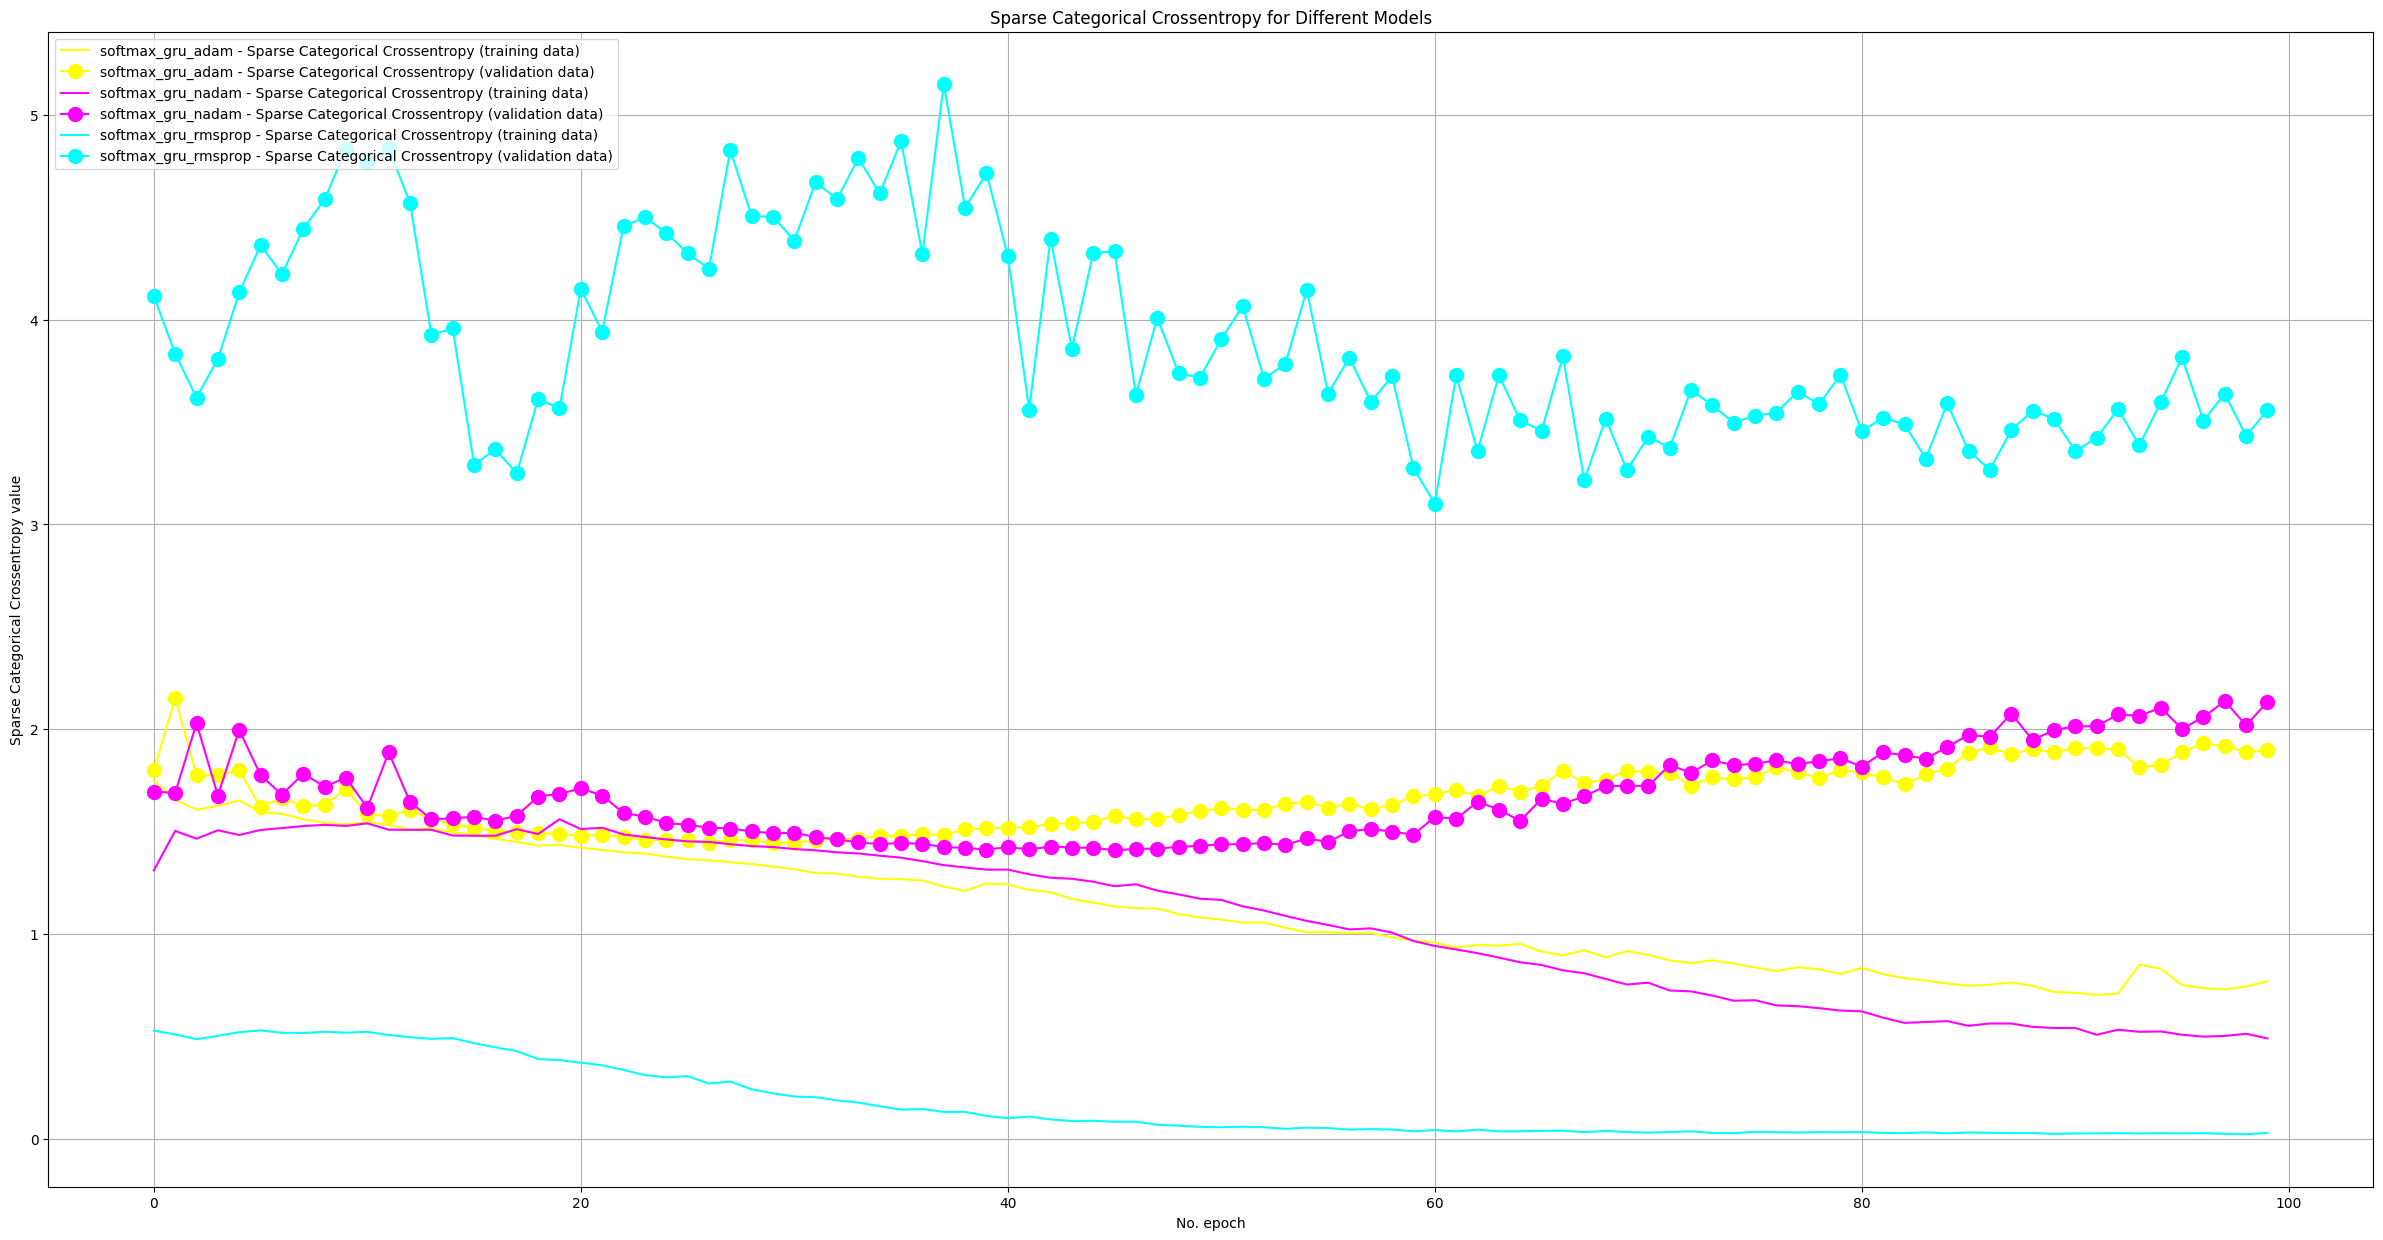

In [69]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['loss'], label=f'{model_name} - Sparse Categorical Crossentropy (training data)', color=color_plot)
    plt.plot(history.history['val_loss'], label=f'{model_name} - Sparse Categorical Crossentropy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Sparse Categorical Crossentropy for Different Models')
plt.ylabel('Sparse Categorical Crossentropy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

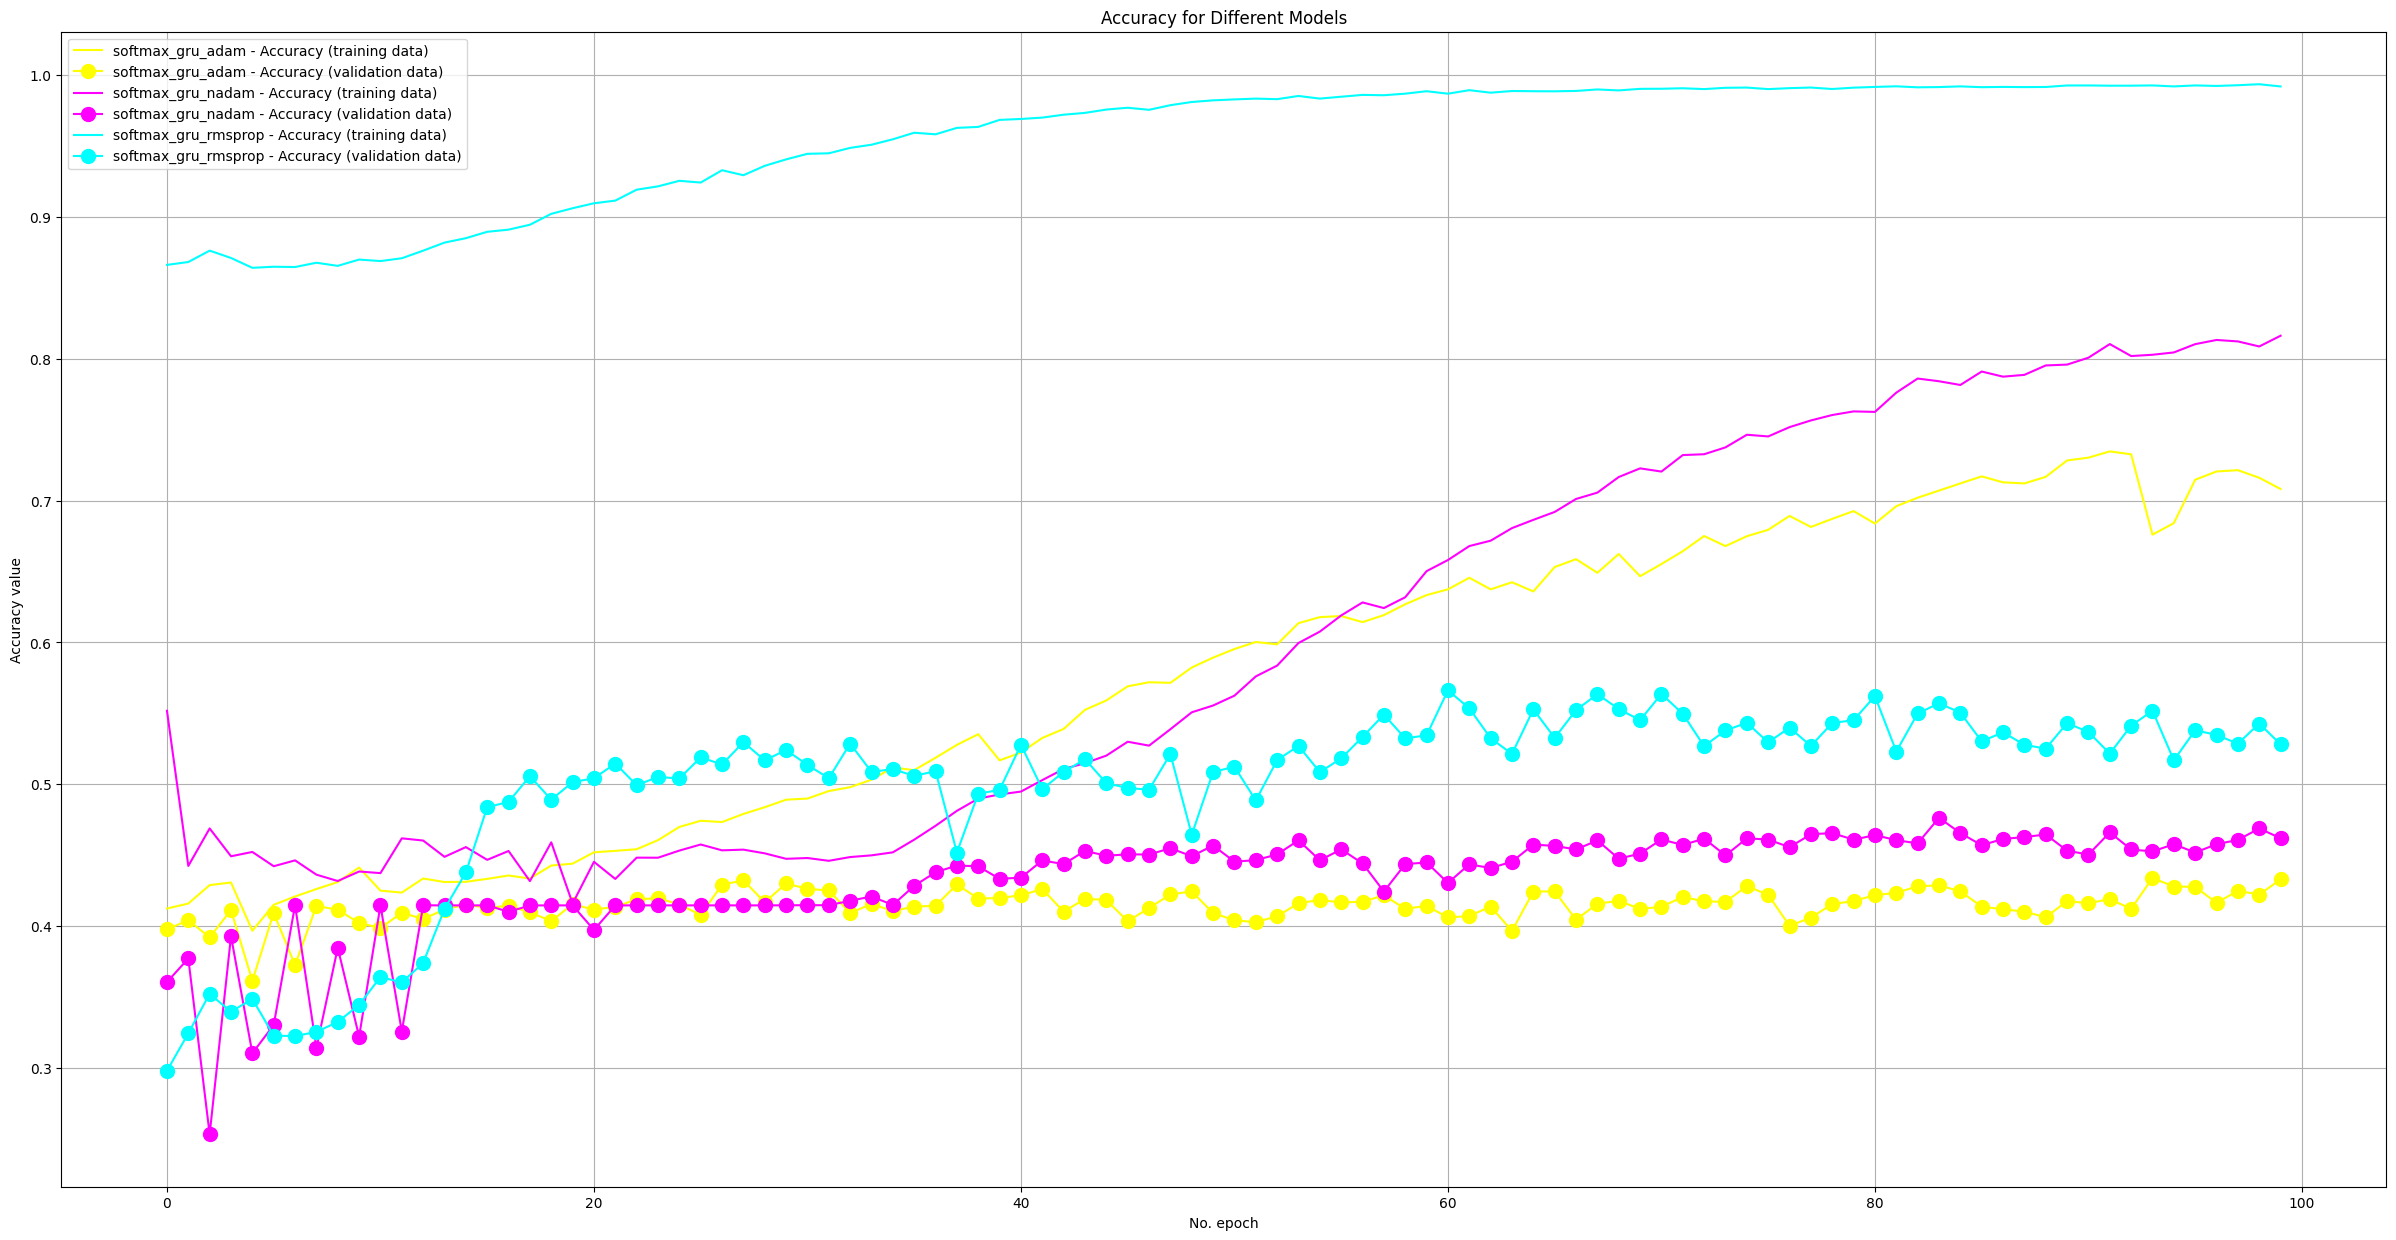

In [70]:
plt.rcdefaults()
plt.figure(figsize=(30,15))

for model_name in models_to_test:
    color_plot = models_to_test[model_name]["color_plot"]
    history = models_to_test[model_name]["history"]
    plt.plot(history.history['accuracy'], label=f'{model_name} - Accuracy (training data)', color=color_plot)
    plt.plot(history.history['val_accuracy'], label=f'{model_name} - Accuracy (validation data)', color=color_plot, marker=".", markersize=20)

plt.title('Accuracy for Different Models')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [71]:
# lstm_model.evaluate(
#     x=features_tensor,
#     y=targets_tensor
# )

## Making Predictions

In [72]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

In [73]:
labels = [
    "Not Defined/Transient",
    "Baseline",
    "Stress",
    "Amusement",
    "Meditation",
    "Error/Not Labeled"
]

In [74]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

In [75]:
len(model_features_validation)

5193

In [76]:
features_tensor_validation =  tf.convert_to_tensor(
    np.array(
        [tf.convert_to_tensor(data) for data in model_features_validation]
    )
)


In [77]:
features_tensor_validation

<tf.Tensor: shape=(5193, 60, 5), dtype=float64, numpy=
array([[[-4.65943125e-02, -9.04284684e-01, -6.64559137e-01,
         -4.89919394e-01,  1.63959898e-01],
        [ 1.51342789e-01,  8.11712260e-01, -1.93284080e+00,
         -1.14633667e+00,  3.45247980e-01],
        [-4.70135591e-01, -1.04226242e-01, -8.41134923e-01,
         -2.13595033e+00, -7.00115834e-01],
        ...,
        [-8.91612405e-01, -1.07396680e+00, -1.87933942e+00,
         -1.39711654e+00, -4.30786096e-02],
        [ 6.48519759e-02, -7.52638404e-01, -2.67509237e+00,
          3.69179308e-01,  4.86917491e-01],
        [-9.09065533e-01, -7.63304895e-01, -7.24960597e-01,
          2.49215201e-01,  2.21087009e-01]],

       [[ 1.51342789e-01,  8.11712260e-01, -1.93284080e+00,
         -1.14633667e+00,  3.45247980e-01],
        [-4.70135591e-01, -1.04226242e-01, -8.41134923e-01,
         -2.13595033e+00, -7.00115834e-01],
        [ 1.06858273e-01,  1.07392247e+00, -2.10743732e+00,
         -9.96365130e-01,  1.30739834e

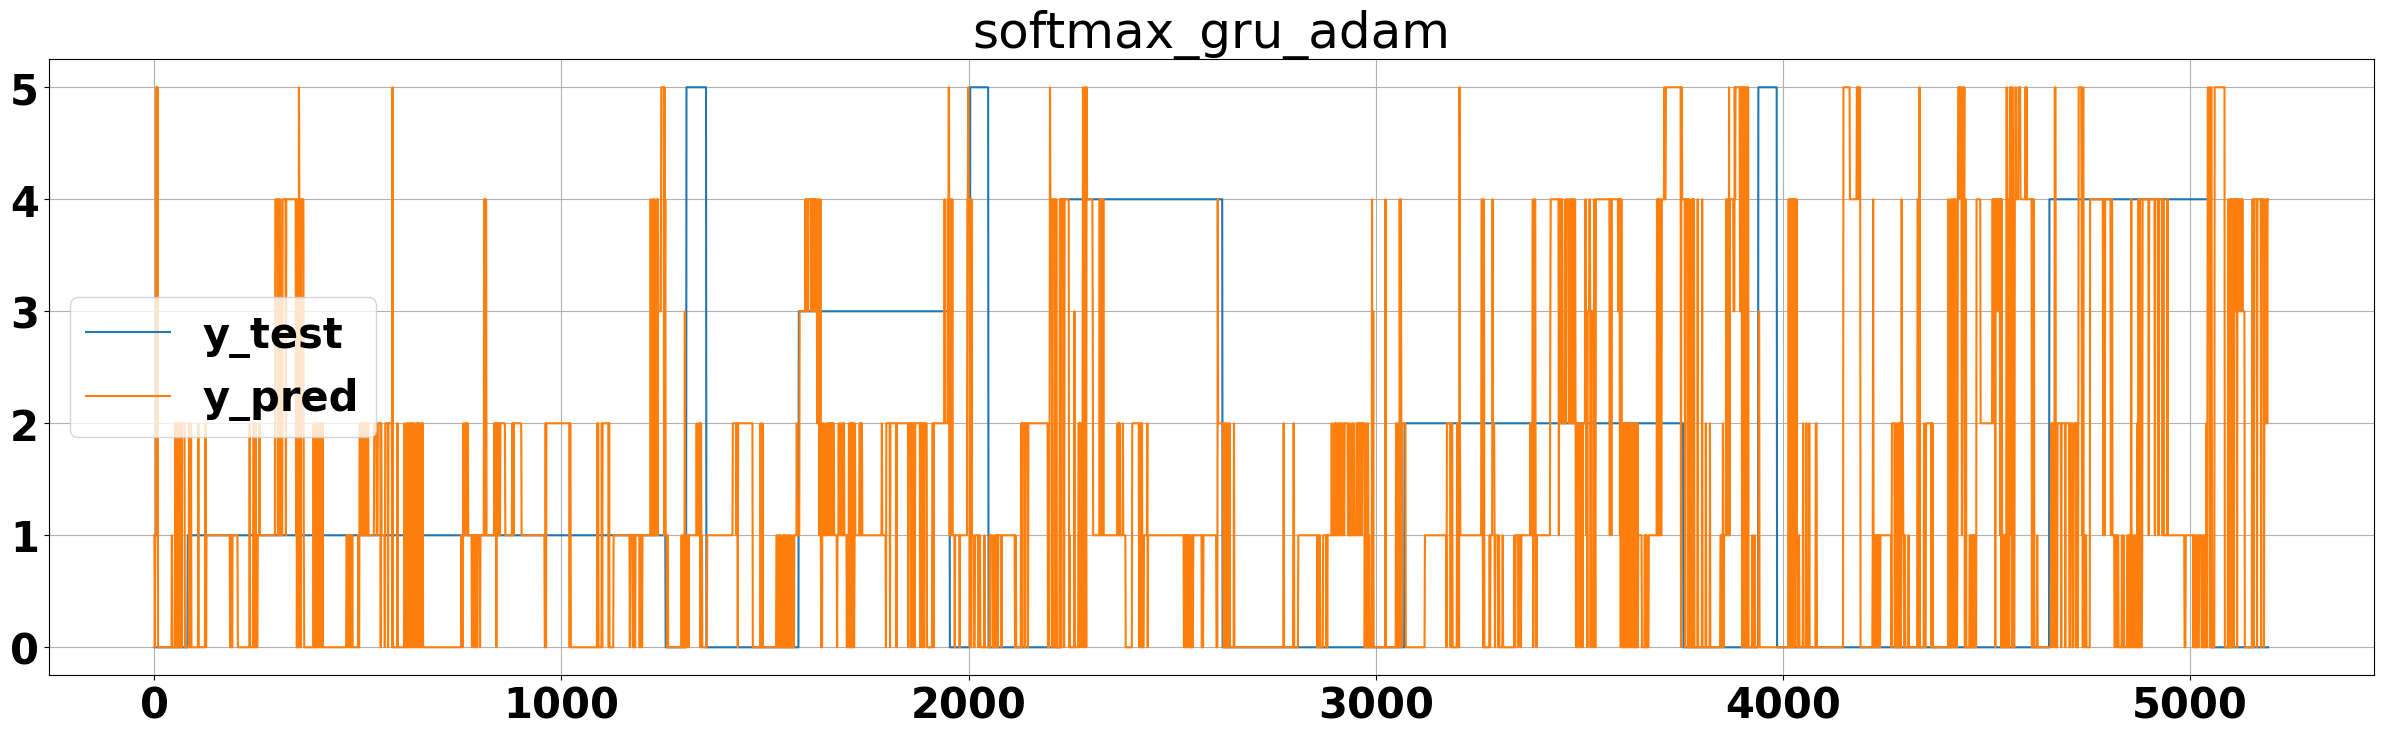

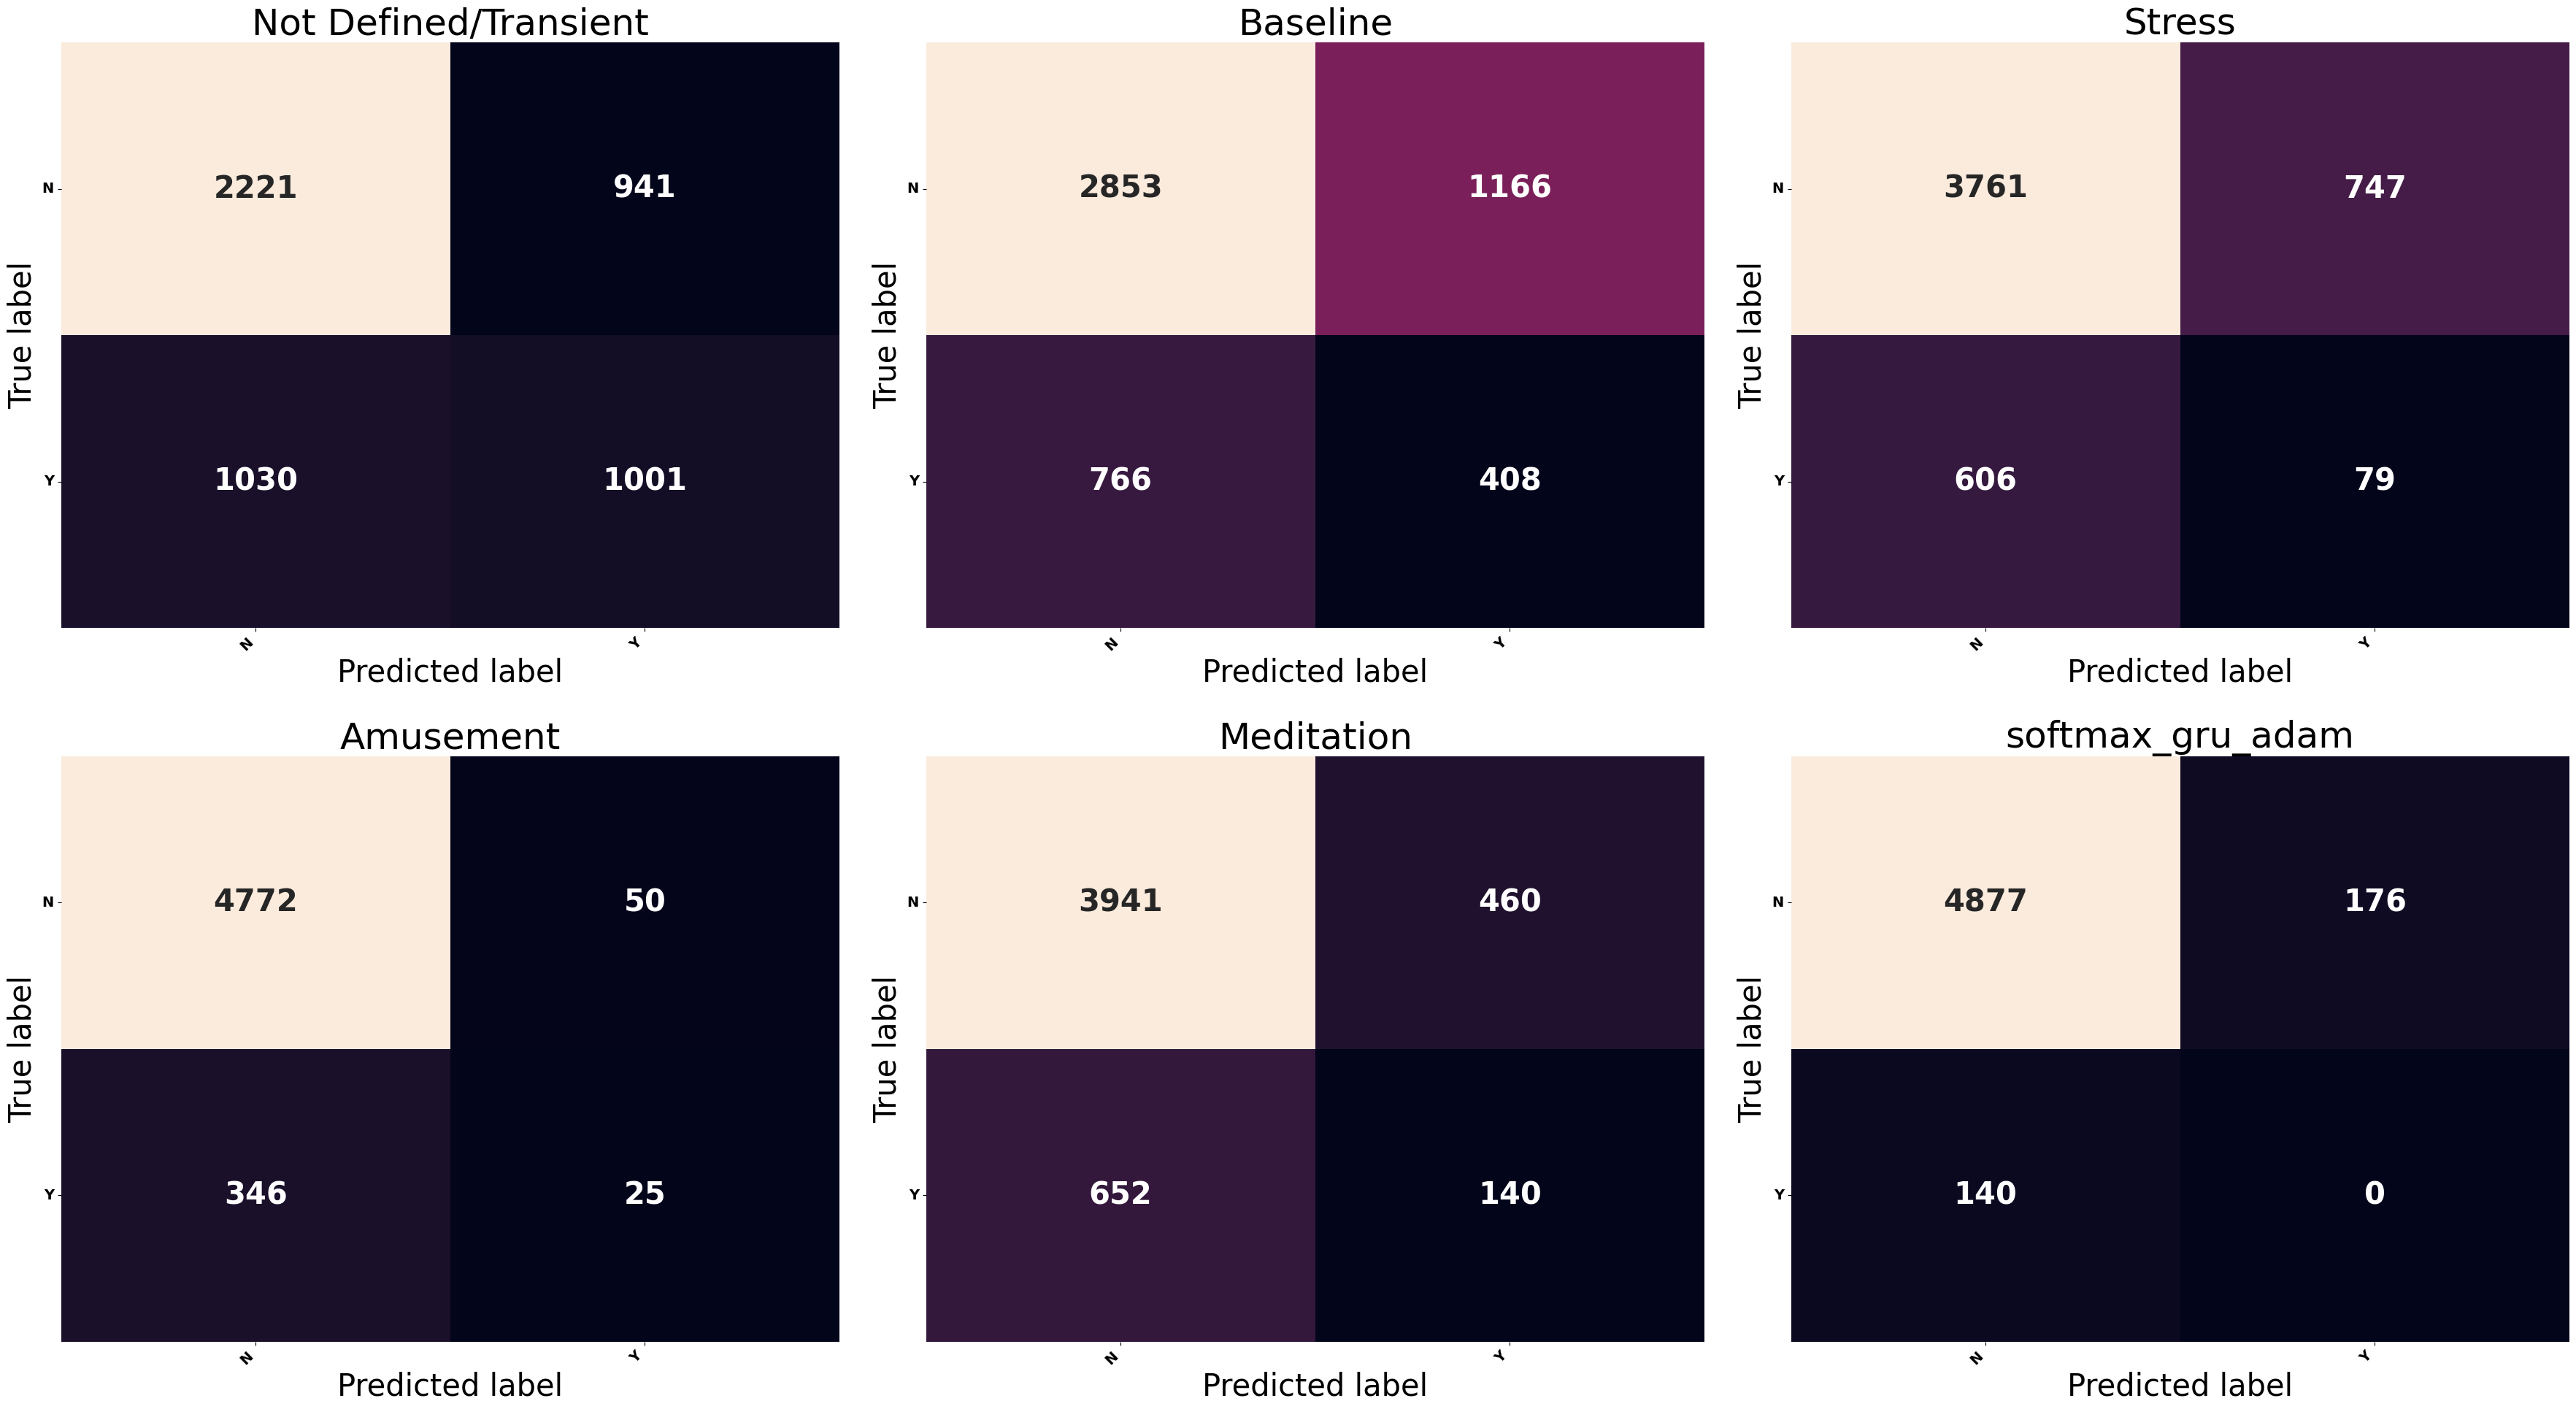

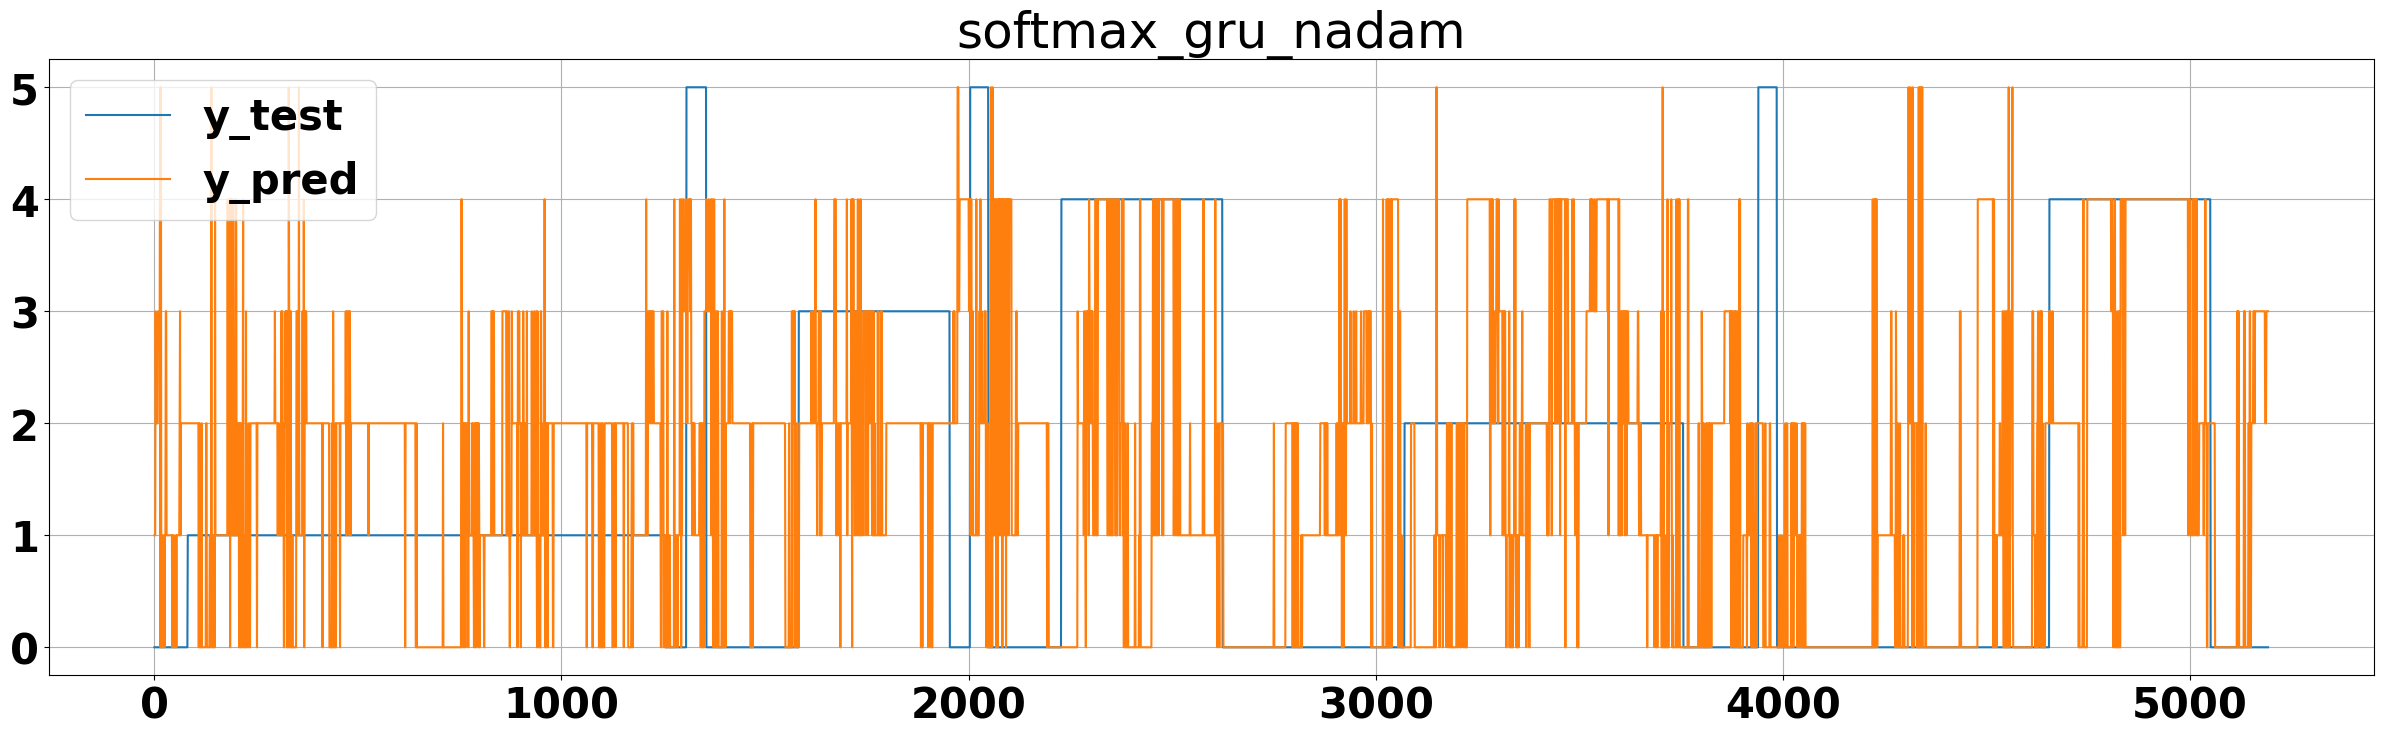

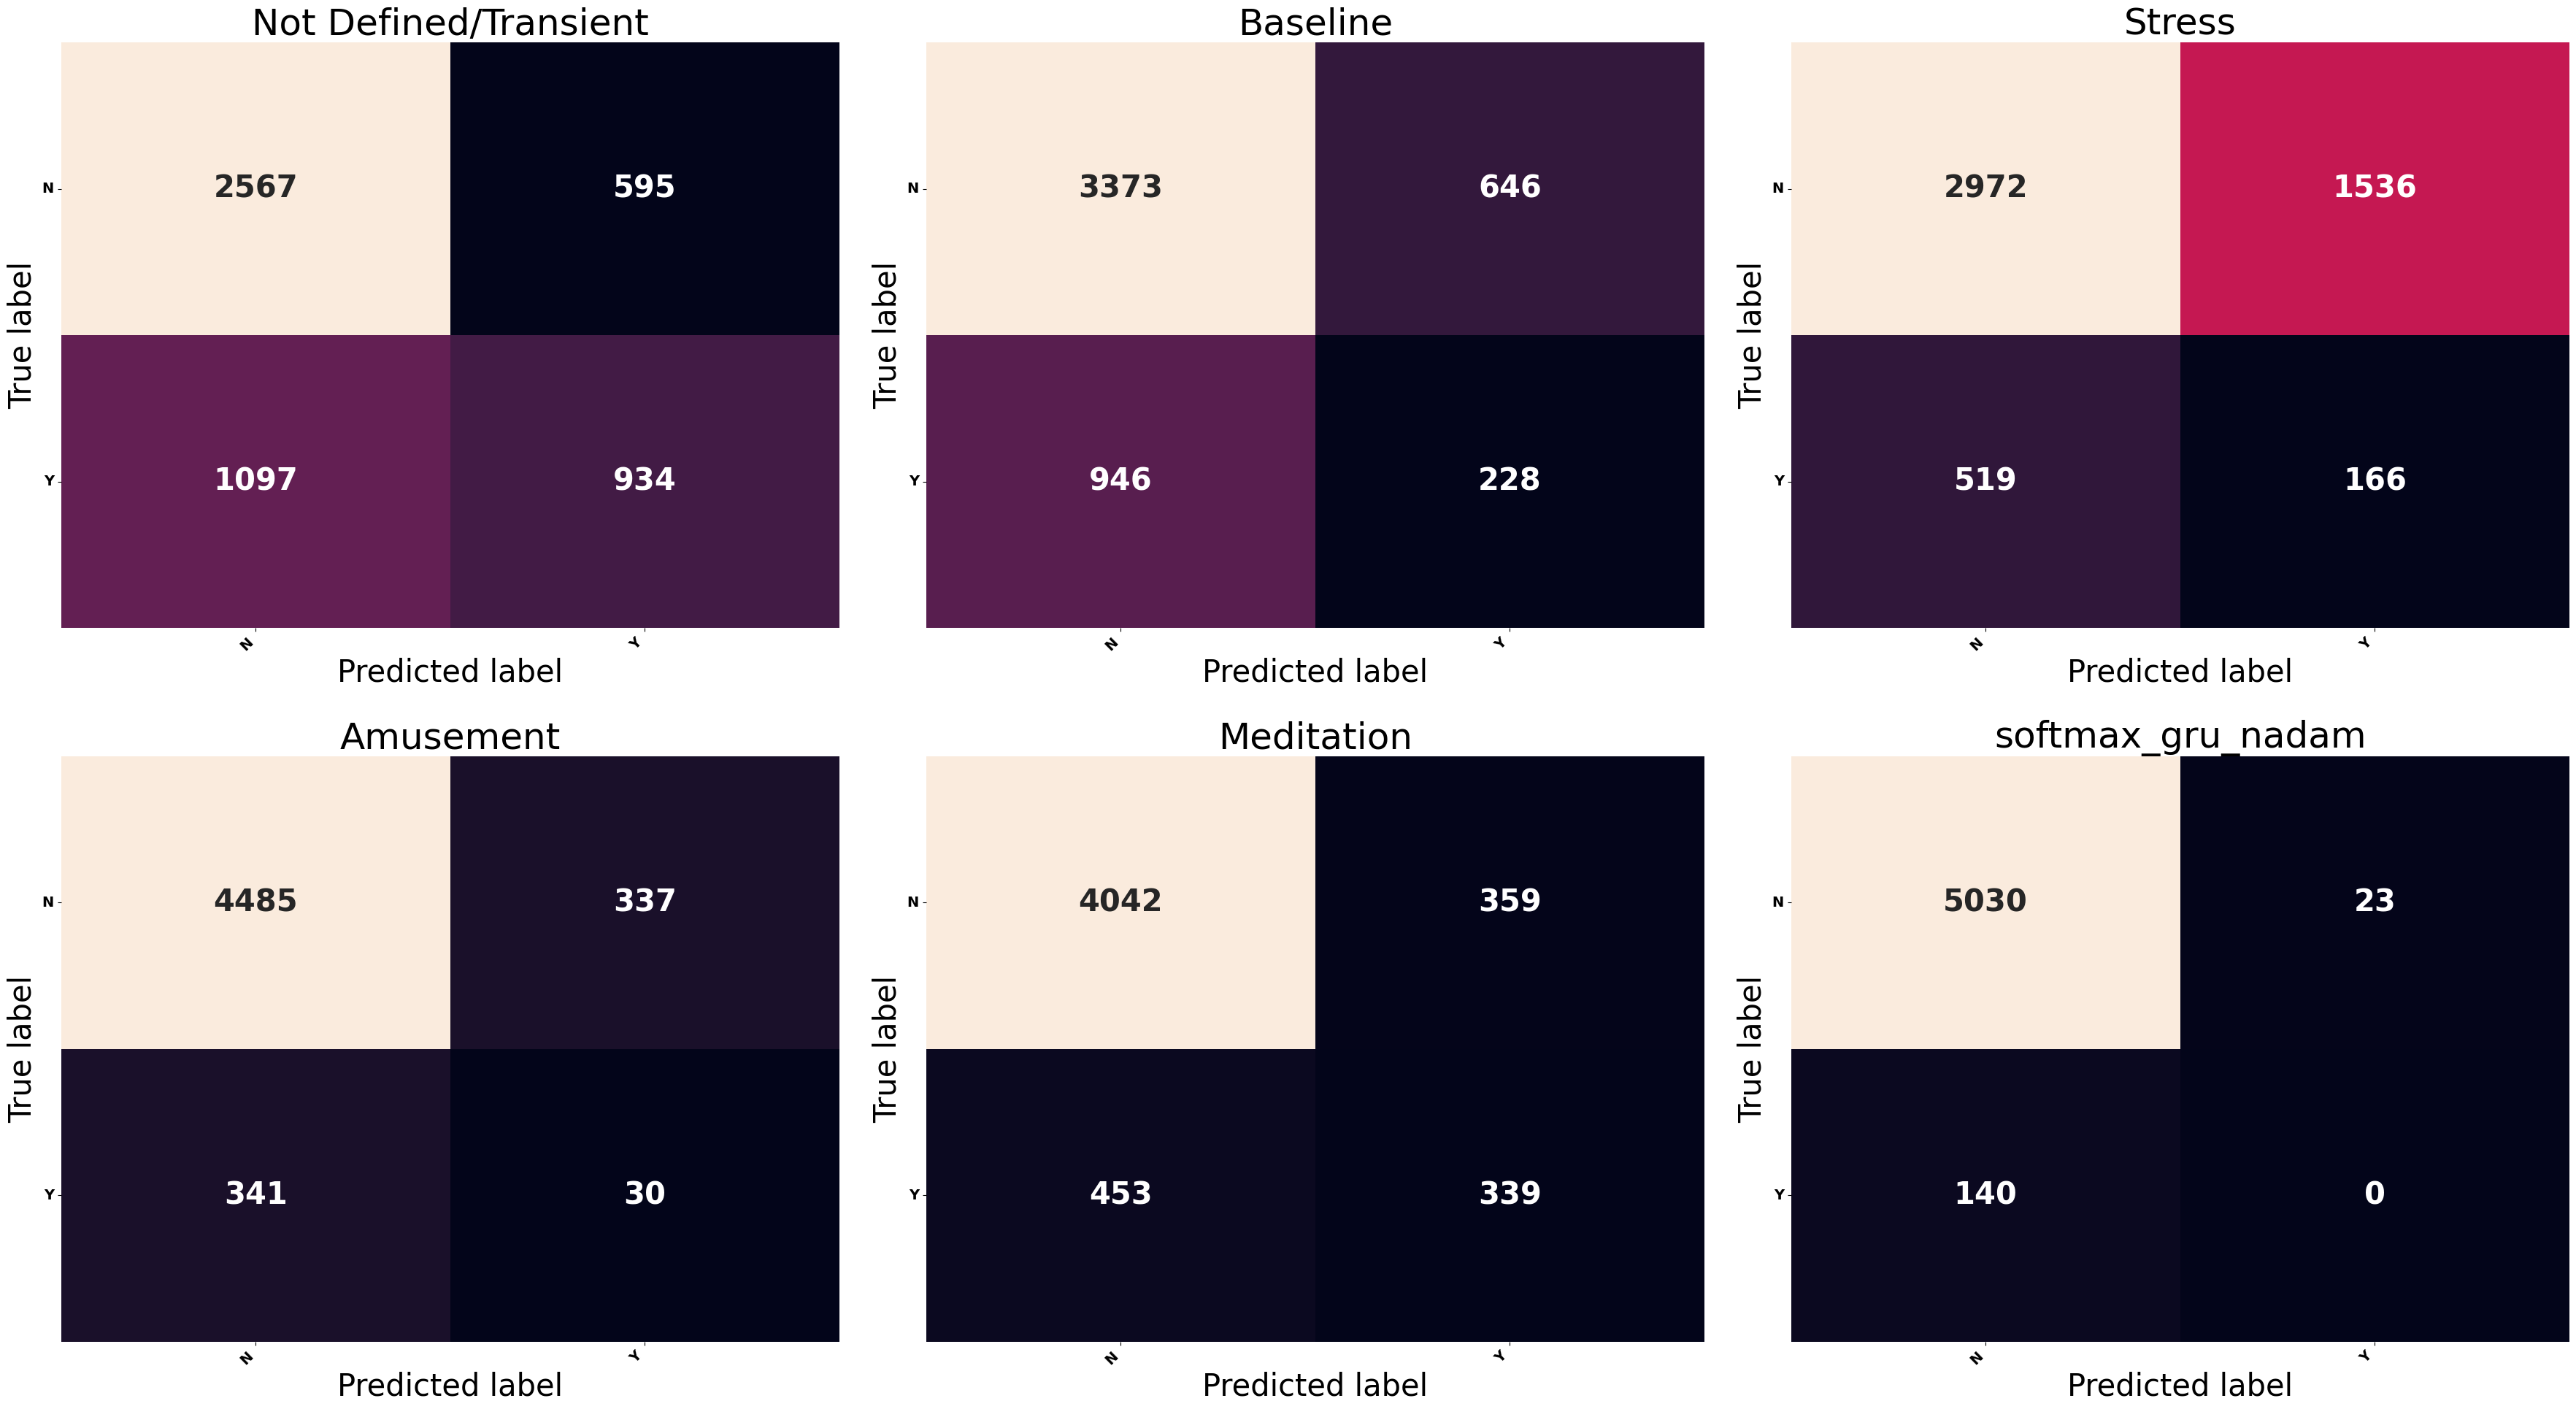

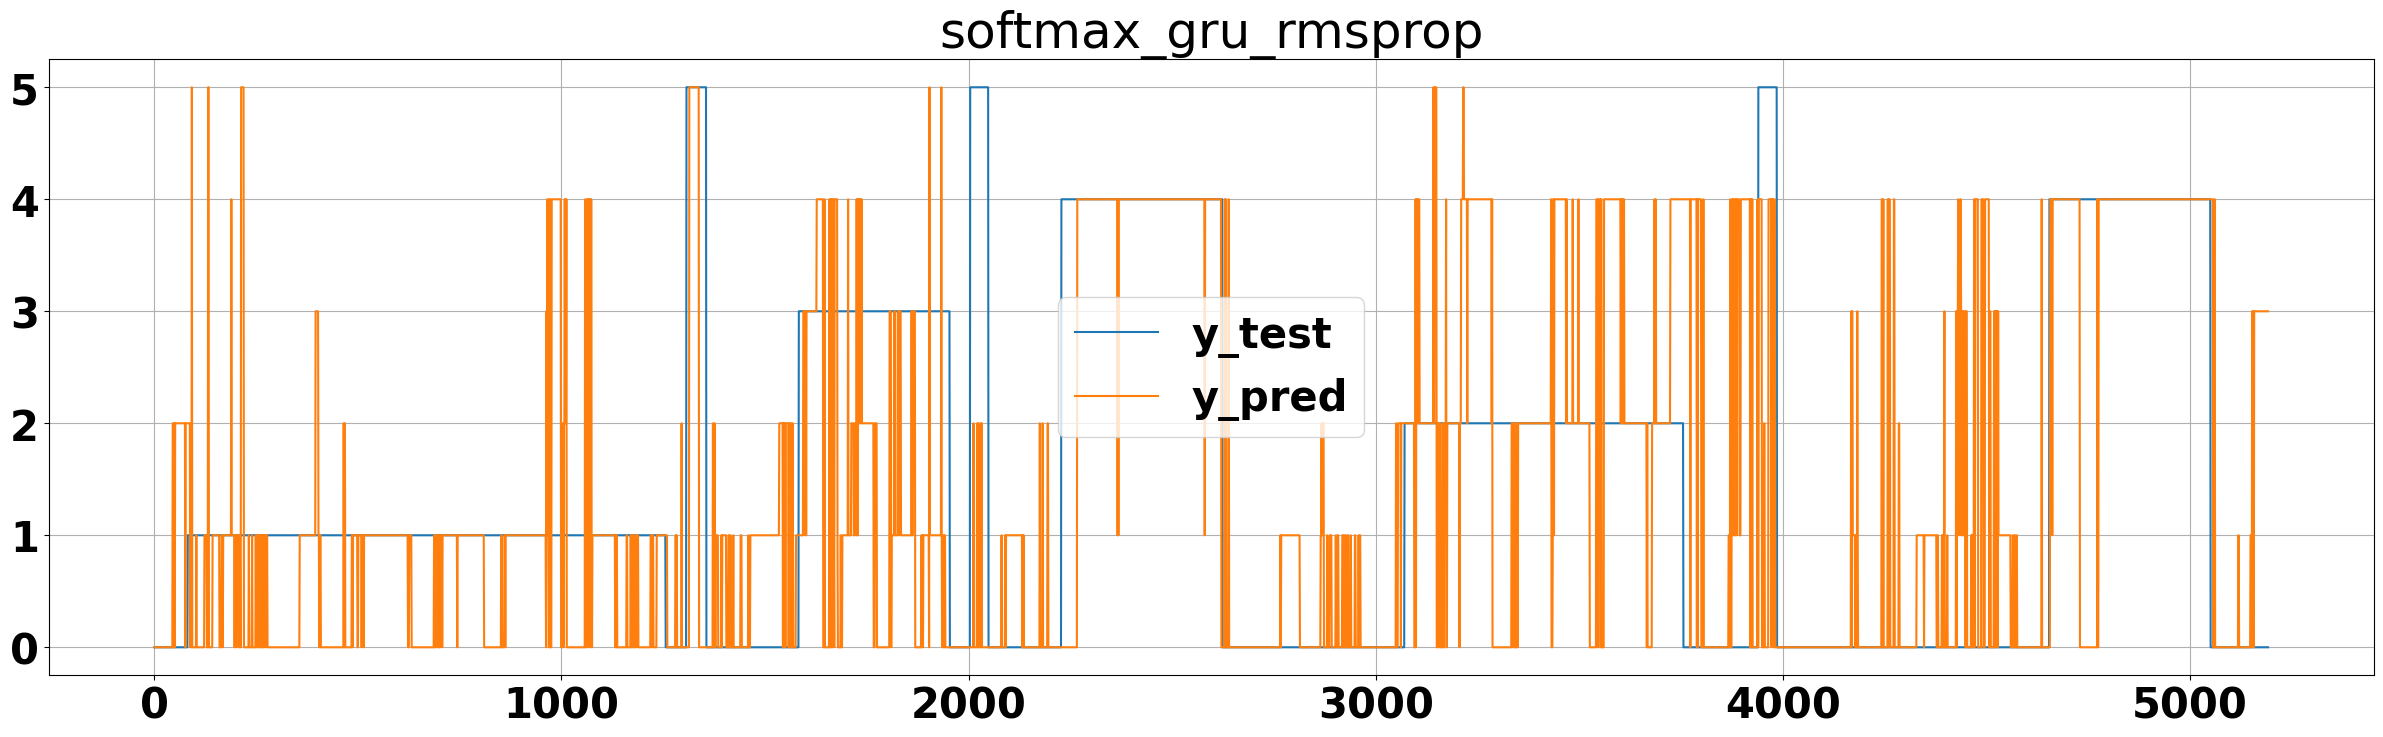

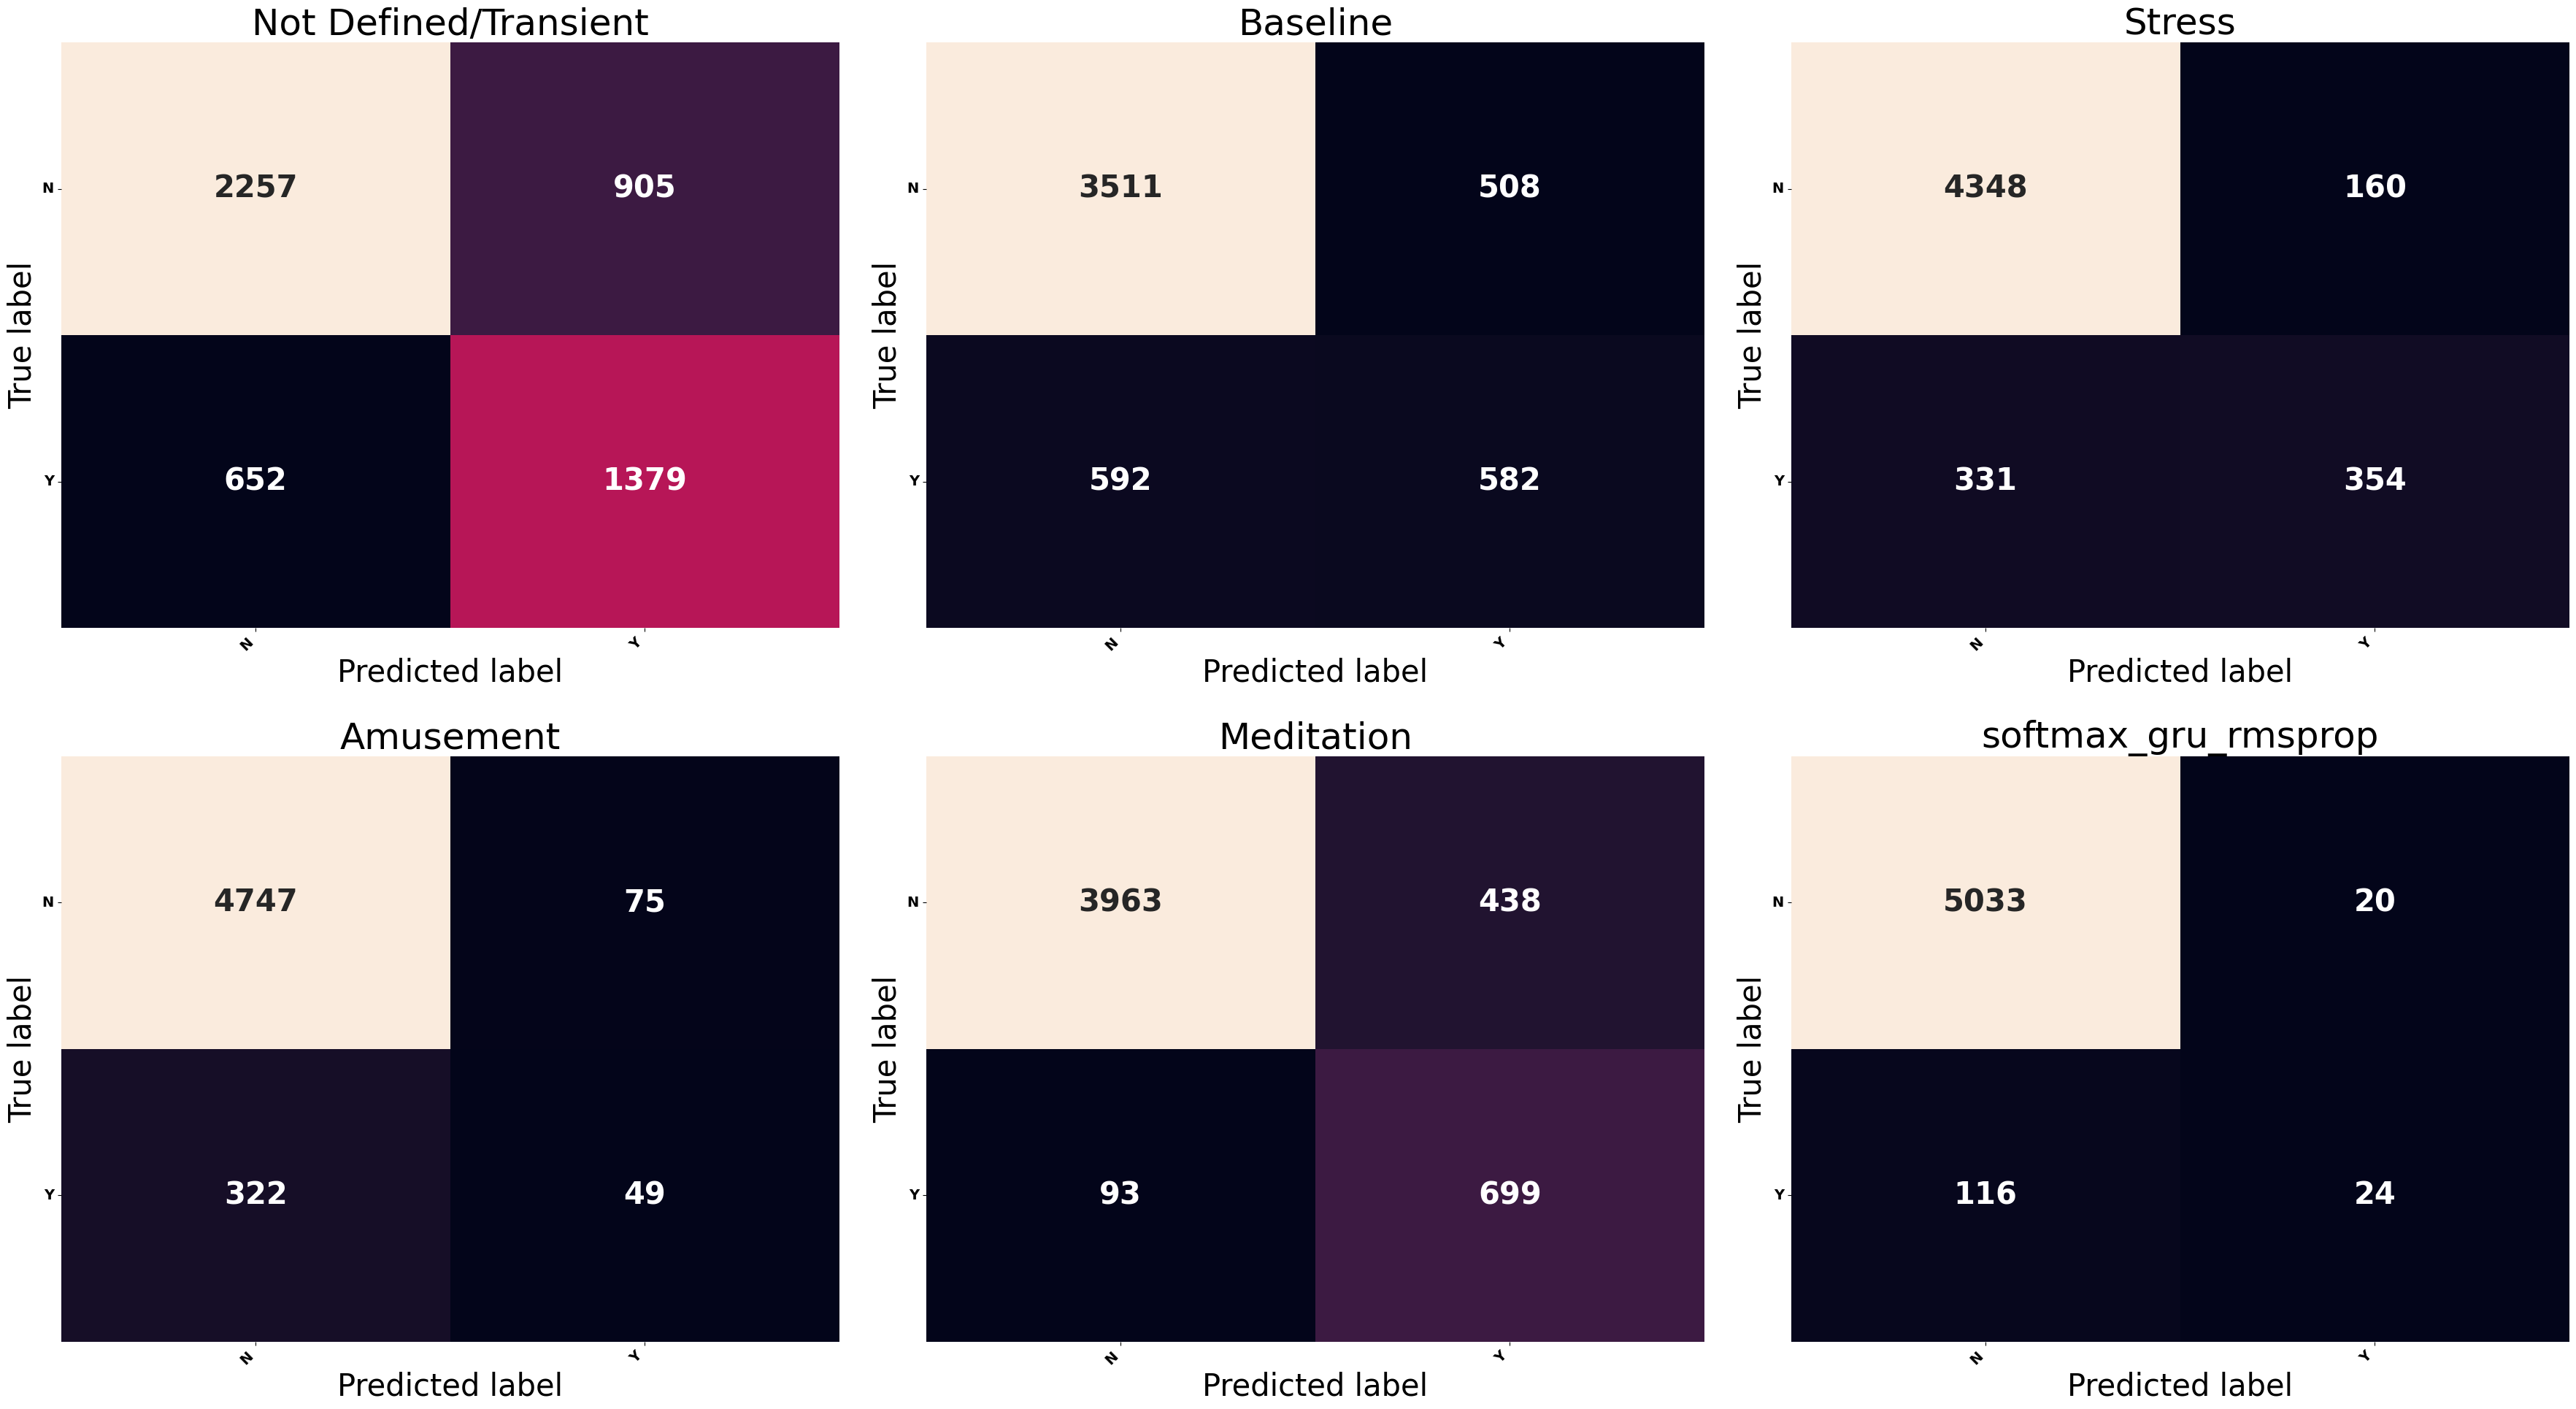

In [78]:
font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 30}
plt.rc("font",**font)

y_test = model_targets_validation

for model_name in models_to_test:
    y_pred_prob = models_to_test[model_name]["model"].predict( x = features_tensor_validation )

    predictions = []
    for i in range(len(y_pred_prob)):
        predictions.append(np.argmax(y_pred_prob[i]))
    
    y_pred = np.array(predictions)
    models_to_test[model_name]["predictions"] = y_pred

    df_y = pd.DataFrame({
        "y_test": y_test,
        "y_pred": y_pred
    })

    models_to_test[model_name]["pred_image"] = df_y.plot(figsize=(30, 8), grid=True).get_figure()
    plt.title(model_name)

    y_test_label = np.array([pacient_state[i] for i in y_test])
    y_pred_label = np.array([pacient_state[i] for i in y_pred])

    confusion_matrix = multilabel_confusion_matrix(y_test_label, y_pred_label, labels=labels)

    models_to_test[model_name]["confusion_matrix"] = confusion_matrix

    fig, ax = plt.subplots(2, 3, figsize=(36, 20))

    

    for axes, cf_matrix, label in zip(ax.flatten(), confusion_matrix, labels):
        print_confusion_matrix(cf_matrix, axes, label, ["N", "Y"])
    fig.tight_layout()
    plt.title(model_name)
    

    models_to_test[model_name]["confusion_matrix_image"] = fig

In [79]:
models_to_test

{'softmax_gru_adam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'yellow',
  'layers': <function __main__.gru(model=None)>,
  'optimizer': 'adam',
  'callbacks': [<keras.callbacks.TensorBoard at 0x17a5b7940>],
  'history': <keras.callbacks.History at 0x17a5876a0>,
  'model': <keras.engine.sequential.Sequential at 0x17a5b72e0>,
  'predictions': array([1, 0, 1, ..., 2, 4, 4]),
  'pred_image': <Figure size 3000x800 with 1 Axes>,
  'confusion_matrix': array([[[2221,  941],
          [1030, 1001]],
  
         [[2853, 1166],
          [ 766,  408]],
  
         [[3761,  747],
          [ 606,   79]],
  
         [[4772,   50],
          [ 346,   25]],
  
         [[3941,  460],
          [ 652,  140]],
  
         [[4877,  176],
          [ 140,    0]]]),
  'confusion_matrix_image': <Figure size 3600x2000 with 6 Axes>},
 'softmax_gru_nadam': {'has_activator': True,
  'activator_layer': 'softmax',
  'color_plot': 'magenta',
  'layers': <function __main__.gru(model

## Testing Area

In [80]:
# sigmoid_predictions = models_to_test["sigmoid"]["predictions"]
softmax_predictions = models_to_test["softmax"]["predictions"]
# no_activator_predictions = models_to_test["no_activatior"]["predictions"]

KeyError: 'softmax'

In [ ]:
# sigmoid_predictions
softmax_predictions
# no_activator_predictions

In [ ]:
softmax_predictions.shape

In [ ]:
sum(softmax_predictions[0])

In [ ]:
predictions = []
for i in range(len(softmax_predictions)):
    predictions.append(np.argmax(softmax_predictions[i]))

In [ ]:
len(predictions)

In [ ]:
predictions_array = np.array(predictions)

In [ ]:
predictions_array

In [ ]:
model_targets_validation

In [ ]:
targets_tensor_validation = tf.convert_to_tensor(model_targets_validation, dtype="int64")

In [ ]:
test_loss, test_acc = model.evaluate(features_tensor_validation, targets_tensor_validation, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
df_y = pd.DataFrame({
    "y_test": model_targets_validation,
    "y_pred": predictions_array
})

df_y.head(10)

In [ ]:
df_y.plot(figsize=(30, 8), grid=True)

In [ ]:
np.argmax(no_activator_predictions[0])

In [ ]:
max(no_activator_predictions)

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(range(len(no_activator_predictions)) ,no_activator_predictions)


In [ ]:
# sigmoid_predictions[0]
softmax_predictions[0]

In [ ]:
# sigmoid_predictions[1]
softmax_predictions[1]

In [ ]:
def test_predictions(predictions_test, num_labels):
    label_index_teste = np.argmax(predictions_test[0][:num_labels])
    state_index_teste = np.argmax(predictions_test[0][num_labels:])

    for array in predictions_test:
        if (label_index_teste != np.argmax(array[:num_labels])) and (state_index_teste != np.argmax(array[num_labels:])):
            print("Exist at least one different prediction")
            return
    print("Does not exist different predictions")


In [ ]:
test_predictions(softmax_predictions, num_labels)

In [ ]:
test_predictions(sigmoid_predictions, num_labels)

In [ ]:
test_predictions(no_activator_predictions, num_labels)

In [ ]:
def transform_prediction(prediction_np, num_states, num_labels):
    zeros_base_array = np.zeros(num_labels + num_states)

    label_index = np.argmax(prediction_np[:num_labels])
    state_index = np.argmax(prediction_np[num_labels:])

    zeros_base_array[label_index] = 1
    zeros_base_array[num_labels + state_index] = 1

    return zeros_base_array

In [ ]:
transformed_array_list = []


for prediction in sigmoid_predictions:
    binary_array = transform_prediction(prediction, num_states, num_labels).reshape(1, num_states + num_labels)
    transformed_array_list.append(binary_array)


In [ ]:
fittable_econder_array = np.concatenate(transformed_array_list, axis=0)

In [ ]:
unique_values = np.unique(fittable_econder_array, axis=0)

unique_values

In [ ]:
enc.inverse_transform(fittable_econder_array)

In [ ]:
enc.get_feature_names()

In [ ]:
target_validation_array_list = []

for array in model_targets_validation:
    target_validation_array_list.append(array.reshape(1,14))

target_validation_array = np.concatenate(target_validation_array_list, axis=0)

In [ ]:
target_validation_array

In [ ]:
target_validation_array[0]

In [ ]:
target_validation_array[1]

In [ ]:
unique_values1 = np.unique(target_validation_array, axis=0)

unique_values1

In [ ]:
np.concatenate(target_validation_array_list, axis=0)

In [ ]:
labeled_validation = enc.inverse_transform(model_targets_validation.tolist())

In [ ]:
labeled_validation